# Forecast model

This notebook is dedicated to the development of a forcast model. Unlike the previous model this does not for under the paradigm of a rolling forecast model. It is divided into the following parts:
   * Final data preparation
       * Here we take care of the last few steps in preparing our data for model development
       
   * Model selection
       * In this section we test the performance of the following model and select the best performing model:
           * XGboost
           * Linear Regression
           * LSTM
           
   * Making predictions
       * In this section we utilise the best performing model (xgboost) and make predictions for each month from 2023-01-01 until 2025-01-01
       * The section ends with an illustration of the number of signups predicted by the model (xgboost).
       
#### According to this modelling approach there will be an additional 1 060 896 signups by 1 Jan 2025. Which means there will be a total of 2 560 896 signups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Final data preparation

In [2]:
#Import shop data
def import_data() -> pd.DataFrame:
    """
    Import data from file.
    :return: pd.DataFrame containing data
    """
    df = pd.read_csv('data_prepared.csv')
    #convert date object column to datetime
    df['date_column'] =  pd.to_datetime(df['date_column'])
    #Set date column as index
    df = df.set_index('date_column')
    
    return df

df = import_data()
df.head()

,num_signups,num_signups_one_back,num_signups_twelve_back,year,month,province_eastern cape,province_free state,province_gauteng,province_kwazulu natal,province_limpopo,province_mpumalanga,province_north west,province_northern cape,province_western cape
date_column,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,2018,1,1,0,0,0,0,0,0,0,0
2018-02-01,1.0,0.0,0.0,2018,2,1,0,0,0,0,0,0,0,0
2018-03-01,0.0,1.0,0.0,2018,3,1,0,0,0,0,0,0,0,0
2018-04-01,2.0,0.0,0.0,2018,4,1,0,0,0,0,0,0,0,0
2018-05-01,0.0,2.0,0.0,2018,5,1,0,0,0,0,0,0,0,0


In [3]:
#Split train/test set
def split_data(df_func: pd.DataFrame, split_date: datetime) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into 2 DataFrames according to the received split_date, one containing training data
    and the other containing testing data.
    :param df_func: pd.DataFrame containing all sales data
    :param split_date: Datetime object detailing the date on which to split the data
    :return: pd.DataFrame, one for training data, one for testing data
    """
    df_train = df_func.loc[df_func.index < split_date].copy()
    df_test = df_func.loc[df_func.index >= split_date].copy()

    return df_train, df_test

#Split data
split_date = '1-Jan-2023'
df_train, df_test = split_data(df, split_date)

 
 
Below the training and testing data containing signups across all provinces is illustrated


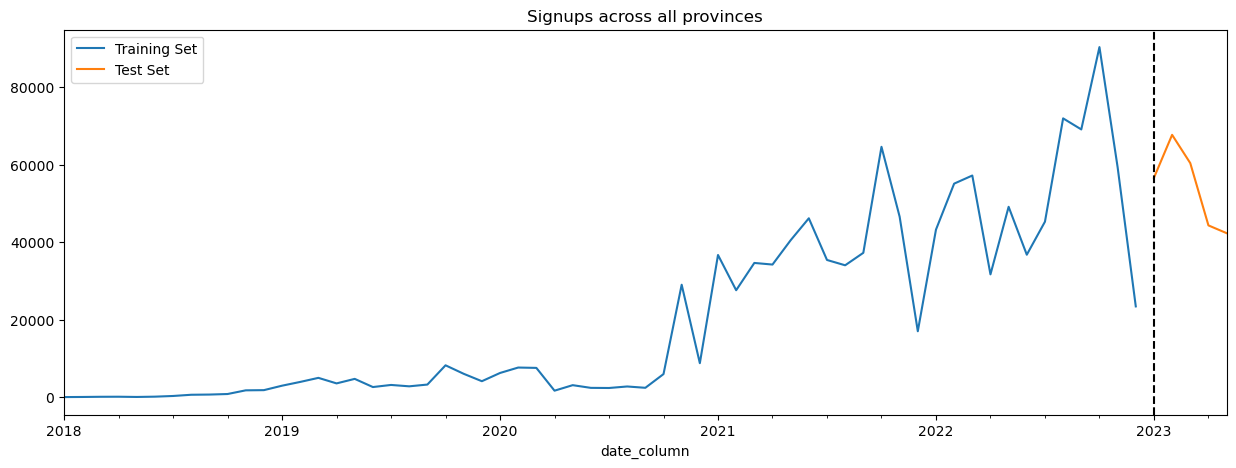

In [4]:
#Plot train/test data
def plot_train_test_data(df_train_func: pd.DataFrame, 
                         df_test_func: pd.DataFrame, 
                         split_date: datetime) -> None:
    """
    Generate plot illustrating train and test data wrt total signups in all provinves at each timestep.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :param split_date: Date on which training and testing data was split
    """
    #Aggragate data for plot
    df_train_func = df_train_func.groupby(by='date_column').agg({'num_signups':'sum'})
    df_test_func = df_test_func.groupby(by='date_column').agg({'num_signups':'sum'})
    
    print(' ')
    print(' ')
    print(f'Below the training and testing data containing signups across all provinces is illustrated')
    
    #Create plot
    fig, ax = plt.subplots(figsize=(15, 5))
    df_train_func.plot(ax=ax, label='Training Set', title='Signups across all provinces')
    df_test_func.plot(ax=ax, label='Test Set')
    ax.axvline(split_date, color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()
    
#Plot train/test
plot_train_test_data(df_train, df_test, split_date)

In [5]:
#reset index of dfs
def reset_indx(df_train_func: pd.DataFrame, df_test_func: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Reset index of dataframes.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :return: tuple[pd.DataFrame, pd.DataFrame], one for training data, one for testing
    """
    df_train_func = df_train_func.reset_index()
    df_test_func = df_test_func.reset_index()
    
    return df_train_func, df_test_func

#Reset index
df_train, df_test = reset_indx(df_train, df_test)

In [6]:
#Drop unwanted columns
def drop_columns(df_train_func: pd.DataFrame, 
                 df_test_func: pd.DataFrame, 
                 columns_to_drop: list) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove the columns we do not want to include as features to the prediction model.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :param columns_to_drop: List of column names to drop
    """
    df_train_func = df_train_func.drop(columns_to_drop, axis=1)
    df_test_func = df_test_func.drop(columns_to_drop, axis=1)
    
    return df_train_func, df_test_func

#drop unwanted columns
columns_to_drop = ['date_column', 'num_signups_one_back', 'num_signups_twelve_back']
df_train, df_test = drop_columns(df_train, df_test, columns_to_drop)

In [7]:
#Capture Features and target names
def extract_feats_target(df_train_func: pd.DataFrame, target: str) -> tuple[list, str]:
    """
    Capture features and target names.
    :param df_train_func: pd.DataFrame containing training data
    :return: tuple[list, str], list of feature names, string of target name
    """
    FEATURES = list(df_train_func)
    FEATURES.remove(target)
    TARGET = target
    
    return FEATURES, TARGET

#Identify features and target names
FEATURES, TARGET = extract_feats_target(df_train, 'num_signups') 

In [8]:
#Create Xs & Ys
def create_x_y(train: pd.DataFrame, 
               test: pd.DataFrame, 
               feats: list, 
               targ: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Seperate train and test dataframes into separate dataframes according to the feature and target split.
    :param train: pd.DataFrame containing the training data
    :param test: pd.DataFrame containing the testing data
    :param feats: List of the feature names
    :param targ: String of the target name
    :return: X_train, y_train, X_test, y_test
    """
    X_train = train[feats]
    y_train = train[targ]

    X_test = test[feats]
    y_test = test[targ]
    
    return X_train, y_train, X_test, y_test


#Split data
X_train, y_train, X_test, y_test = create_x_y(df_train, df_test, FEATURES, TARGET)

In [9]:
#Scale the data
def scale_data(X_train: pd.DataFrame, 
               y_train: pd.DataFrame, 
               X_test: pd.DataFrame, 
               y_test: pd.DataFrame, 
               columns_to_scale: list) -> tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Standardise the data.
    :param X_train: pd.DataFrame containing the training data's feature set
    :param X_test: pd.DataFrame containing the testing data's feature set
    :param y_train: pd.DataFrame containing the training data's target variable
    :param y_train: pd.DataFrame containing the testing data's target variable
    :return: X_train, y_train, X_test, y_test
    """
    # Initialize the Scaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    X_train[columns_to_scale] = scaler_X.fit_transform(X_train[columns_to_scale])
    X_test[columns_to_scale] = scaler_X.transform(X_test[columns_to_scale])

    # Reshape y to be a 2D array, which is required by the StandardScaler
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    # Do the same for the target
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)

    return X_train, y_train, X_test, y_test, scaler_X, scaler_y

#Scale data
columns_to_scale = ['year', 'month']
X_train, y_train, X_test, y_test, scaler_X, scaler_y = scale_data(X_train, y_train, X_test, y_test, columns_to_scale)

/tmp/ipykernel_1136568/2618414515.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[columns_to_scale] = scaler_X.fit_transform(X_train[columns_to_scale])
/tmp/ipykernel_1136568/2618414515.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columns_to_scale] = scaler_X.transform(X_test[columns_to_scale])


In [10]:
X_train.head()

,year,month,province_eastern cape,province_free state,province_gauteng,province_kwazulu natal,province_limpopo,province_mpumalanga,province_north west,province_northern cape,province_western cape
0,-1.414214,-1.593255,1,0,0,0,0,0,0,0,0
1,-1.414214,-1.303572,1,0,0,0,0,0,0,0,0
2,-1.414214,-1.013890,1,0,0,0,0,0,0,0,0
3,-1.414214,-0.724207,1,0,0,0,0,0,0,0,0
4,-1.414214,-0.434524,1,0,0,0,0,0,0,0,0


In [11]:
#prep predictions
def prepare_preds(model: xgb.XGBRegressor, 
                    scaler_y: StandardScaler,
                    X_test_func: pd.DataFrame, 
                    df_test_func: pd.DataFrame,
                    columns_to_keep: list) -> pd.DataFrame:
    """
    Prepare dataframe containing predictions for ploting and saving to file
    :param model: The received model to be trained
    :param X_test_func: pd.DataFrame containing testing feature data
    :param test_func: pd.DataFrame containing all testing data (features & target)
    :param columns_to_keep: List indicating columns of interest
    :return: pd.DataFrame containing predictions and data of interest
    """
    #save predictions to df
    df_test_func['prediction'] = model.predict(X_test_func)
    # Inverse transform predictions to get them on the original scale
    df_test_func['prediction'] = scaler_y.inverse_transform(df_test_func['prediction'].values.reshape(-1, 1))
    #round predictions to nearest integer
    df_test_func['prediction'] = df_test_func['prediction'].round()
    df_test_func['day'] = 1 #day assigned just for plotting
    df_test_func['date'] = pd.to_datetime(df_test_func[['year', 'month', 'day']])
    df_preds = df_test_func.copy()
    #Set date as index
    df_preds = df_preds.set_index('date')
    # get the columns related to 'province'
    province_cols = [col for col in df_preds.columns if 'province' in col]
    # identify which 'province' column is 1 for each row
    df_preds['province'] = df_preds[province_cols].idxmax(axis=1)
    # remove the 'province_' prefix from the 'province' column
    df_preds['province'] = df_preds['province'].str.replace('province_', '')
    # drop unwanted columns
    df_preds = df_preds[columns_to_keep]
    
    return df_preds

In [12]:
#plot preds
def plot_predictions(df_preds_func: pd.DataFrame) -> None:
    """
    Create plots illustrating predicted vs actual signups.
    :param df_preds_func: pd.DataFrame containing predictions and additional data for saving
    :return: None    """
    provinces = df_preds_func['province'].unique()
    print(' ')
    print(' ')
    print(f'Below are plots illustrating predicted vs actual signups.')
    for province in provinces:
        df_plot = df_preds_func[df_preds_func['province']==province]
        ax = df_plot[['num_signups']].plot(figsize=(15, 5))
        df_plot['prediction'].plot(ax=ax)
        plt.legend(['Truth Data', 'Predictions'])
        ax.set_title(f'{province} Actual Data and Prediction')
        plt.show()

# Model selection

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Create XGboost model

In [13]:
def fit_xgboost_with_grid_search(
    model:xgb.XGBRegressor, 
    param_grid: dict,
    n_splits: int,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    verbose: int = 1) -> GridSearchCV:
    """
    Fit the xgboost model on the time series data with grid search for hyperparameter tuning.
    """
    time_series_split = TimeSeriesSplit(n_splits=n_splits)
    
    grid_search = GridSearchCV(model, param_grid, cv=time_series_split,
                               scoring='neg_mean_squared_error',
                               return_train_score=True,
                               verbose=verbose)
    
    grid_search.fit(X_train, y_train)
    
    print('Best parameters found: ', grid_search.best_params_)
    
    final_model = grid_search.best_estimator_
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    final_model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)
    
    return final_model

param_grid = {
    'max_depth': [3, 5], 
    'learning_rate': [0.01, 0.1], 
    'n_estimators': [500, 1000], 
    'subsample': [0.7, 1.0], 
    'colsample_bytree': [0.7, 1.0], 
    'gamma': [0, 0.25, 0.5]
}

model = fit_xgboost_with_grid_search(model=xgb.XGBRegressor(),
                                   param_grid=param_grid, 
                                   n_splits=5, 
                                   X_train=X_train, 
                                   y_train=y_train, 
                                   X_test=X_test, 
                                   y_test=y_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
[0]	validation_0-rmse:1.10866	validation_1-rmse:1.28312
[1]	validation_0-rmse:1.09947	validation_1-rmse:1.27312
[2]	validation_0-rmse:1.09057	validation_1-rmse:1.26356
[3]	validation_0-rmse:1.08167	validation_1-rmse:1.25401
[4]	validation_0-rmse:1.07258	validation_1-rmse:1.24400
[5]	validation_0-rmse:1.06379	validation_1-rmse:1.23455
[6]	validation_0-rmse:1.05496	validation_1-rmse:1.22521
[7]	validation_0-rmse:1.04662	validation_1-rmse:1.21654
[8]	validation_0-rmse:1.03863	validation_1-rmse:1.20782
[9]	validation_0-rmse:1.02997	validation_1-rmse:1.19834
[10]	validation_0-rmse:1.02193	validation_1-rmse:1.18945
[11]	validation_0-rmse:1.01411	validation_1-rmse:1.18158
[12]	validation_0-rmse:1.00620	validation_1-rmse:1.17318
[13]	validation_0-rmse:0.99823	validation_1-rmse:1.16391
[14]	valid

[140]	validation_0-rmse:0.47687	validation_1-rmse:0.63215
[141]	validation_0-rmse:0.47509	validation_1-rmse:0.63114
[142]	validation_0-rmse:0.47347	validation_1-rmse:0.62867
[143]	validation_0-rmse:0.47184	validation_1-rmse:0.62651
[144]	validation_0-rmse:0.46997	validation_1-rmse:0.62613
[145]	validation_0-rmse:0.46839	validation_1-rmse:0.62534
[146]	validation_0-rmse:0.46697	validation_1-rmse:0.62426
[147]	validation_0-rmse:0.46546	validation_1-rmse:0.62232
[148]	validation_0-rmse:0.46397	validation_1-rmse:0.62065
[149]	validation_0-rmse:0.46250	validation_1-rmse:0.61947
[150]	validation_0-rmse:0.46115	validation_1-rmse:0.61793
[151]	validation_0-rmse:0.45968	validation_1-rmse:0.61632
[152]	validation_0-rmse:0.45815	validation_1-rmse:0.61467
[153]	validation_0-rmse:0.45654	validation_1-rmse:0.61331
[154]	validation_0-rmse:0.45515	validation_1-rmse:0.61283
[155]	validation_0-rmse:0.45370	validation_1-rmse:0.61143
[156]	validation_0-rmse:0.45228	validation_1-rmse:0.61033
[157]	validati

[282]	validation_0-rmse:0.34750	validation_1-rmse:0.55077
[283]	validation_0-rmse:0.34698	validation_1-rmse:0.55090
[284]	validation_0-rmse:0.34657	validation_1-rmse:0.55094
[285]	validation_0-rmse:0.34608	validation_1-rmse:0.55100
[286]	validation_0-rmse:0.34555	validation_1-rmse:0.54989
[287]	validation_0-rmse:0.34518	validation_1-rmse:0.54923
[288]	validation_0-rmse:0.34458	validation_1-rmse:0.54844
[289]	validation_0-rmse:0.34418	validation_1-rmse:0.54821
[290]	validation_0-rmse:0.34368	validation_1-rmse:0.54785
[291]	validation_0-rmse:0.34323	validation_1-rmse:0.54755
[292]	validation_0-rmse:0.34272	validation_1-rmse:0.54749
[293]	validation_0-rmse:0.34204	validation_1-rmse:0.54779
[294]	validation_0-rmse:0.34157	validation_1-rmse:0.54780
[295]	validation_0-rmse:0.34120	validation_1-rmse:0.54787
[296]	validation_0-rmse:0.34065	validation_1-rmse:0.54801
[297]	validation_0-rmse:0.34010	validation_1-rmse:0.54825
[298]	validation_0-rmse:0.33975	validation_1-rmse:0.54791
[299]	validati

[424]	validation_0-rmse:0.29922	validation_1-rmse:0.52987
[425]	validation_0-rmse:0.29907	validation_1-rmse:0.52996
[426]	validation_0-rmse:0.29881	validation_1-rmse:0.52991
[427]	validation_0-rmse:0.29864	validation_1-rmse:0.52957
[428]	validation_0-rmse:0.29840	validation_1-rmse:0.52849
[429]	validation_0-rmse:0.29815	validation_1-rmse:0.52812
[430]	validation_0-rmse:0.29797	validation_1-rmse:0.52764
[431]	validation_0-rmse:0.29764	validation_1-rmse:0.52789
[432]	validation_0-rmse:0.29747	validation_1-rmse:0.52796
[433]	validation_0-rmse:0.29725	validation_1-rmse:0.52755
[434]	validation_0-rmse:0.29700	validation_1-rmse:0.52765
[435]	validation_0-rmse:0.29679	validation_1-rmse:0.52762
[436]	validation_0-rmse:0.29657	validation_1-rmse:0.52750
[437]	validation_0-rmse:0.29641	validation_1-rmse:0.52743
[438]	validation_0-rmse:0.29614	validation_1-rmse:0.52729
[439]	validation_0-rmse:0.29595	validation_1-rmse:0.52730
[440]	validation_0-rmse:0.29567	validation_1-rmse:0.52734
[441]	validati

 
 
Below the feature importance wrt predictions is illustrated


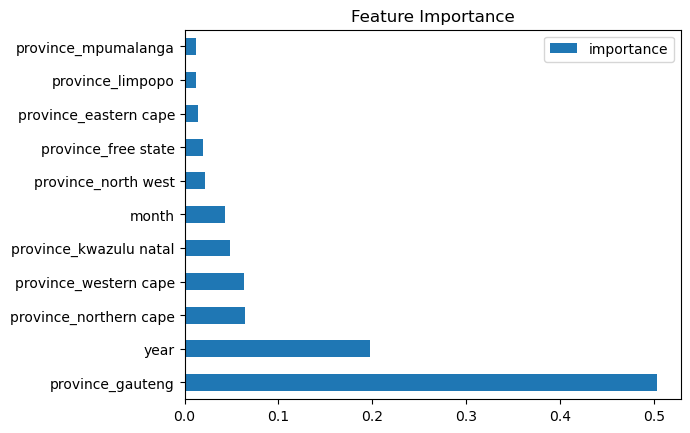

In [14]:
#feature importance
def plot_feature_importance(model: xgb.XGBRegressor) -> None:
    """
    Create a plot of the shop specific feature importance for the trained model.
    :param model: The received model to be trained
    :param shop: Integer indicating the shop
    :return: None
    """
    print(' ')
    print(' ')
    print(f'Below the feature importance wrt predictions is illustrated')
    fi = pd.DataFrame(data=model.feature_importances_,
                 index=model.feature_names_in_,
                 columns=['importance'])
    fi.sort_values('importance', ascending=False)[:20].plot(kind='barh', title='Feature Importance')
    plt.show()
    
#Plot feature importance
plot_feature_importance(model)

In [15]:
#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(model, scaler_y, X_test, df_test, columns_to_keep) 

 
 
Below are plots illustrating predicted vs actual signups.


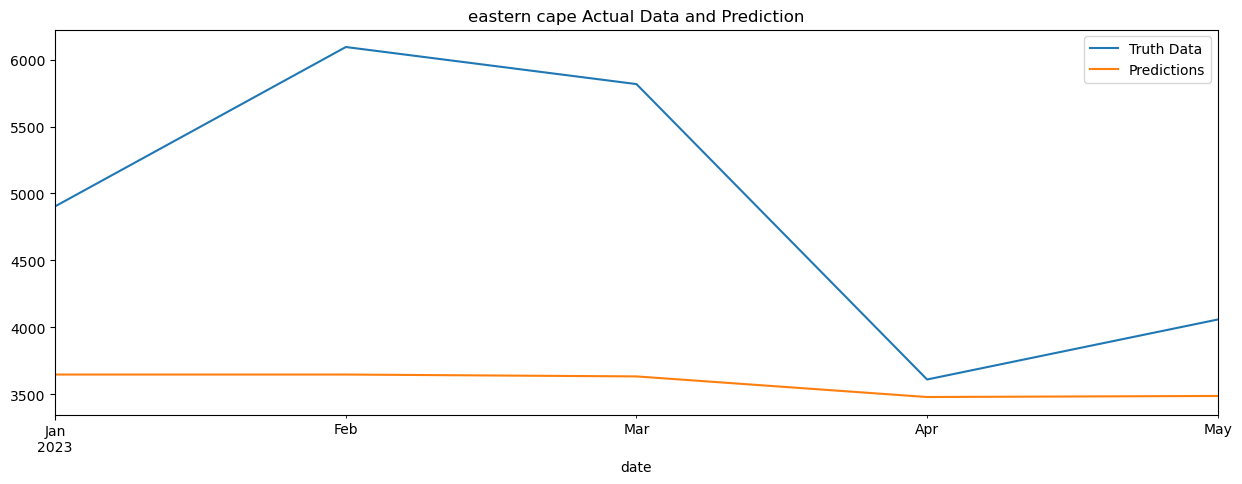

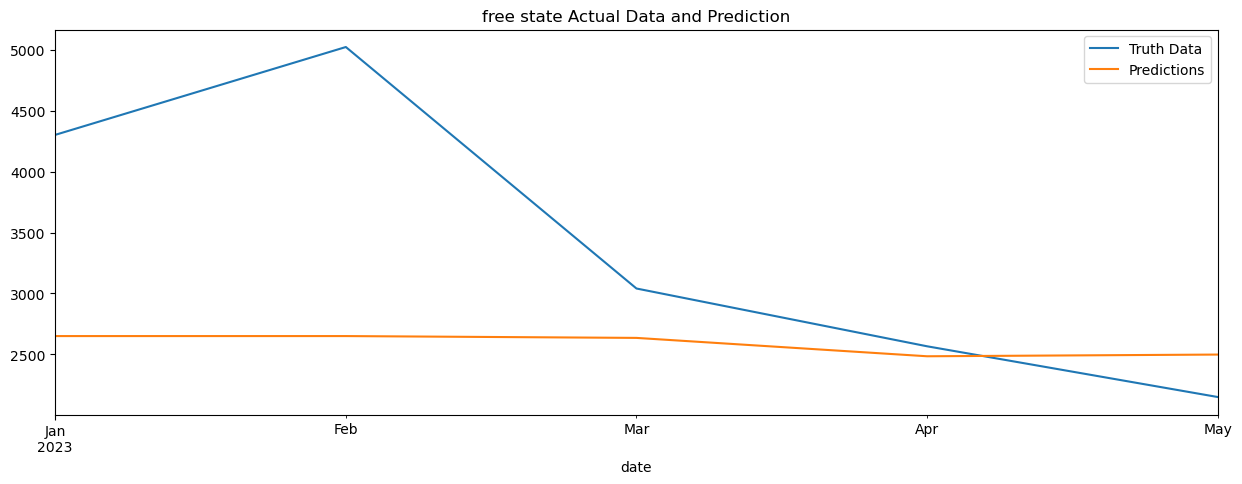

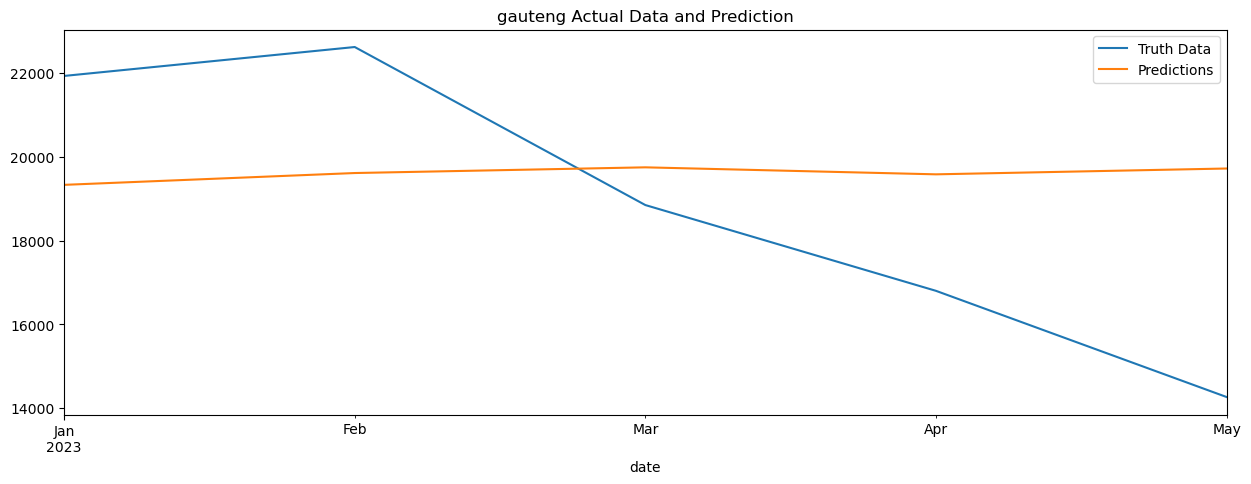

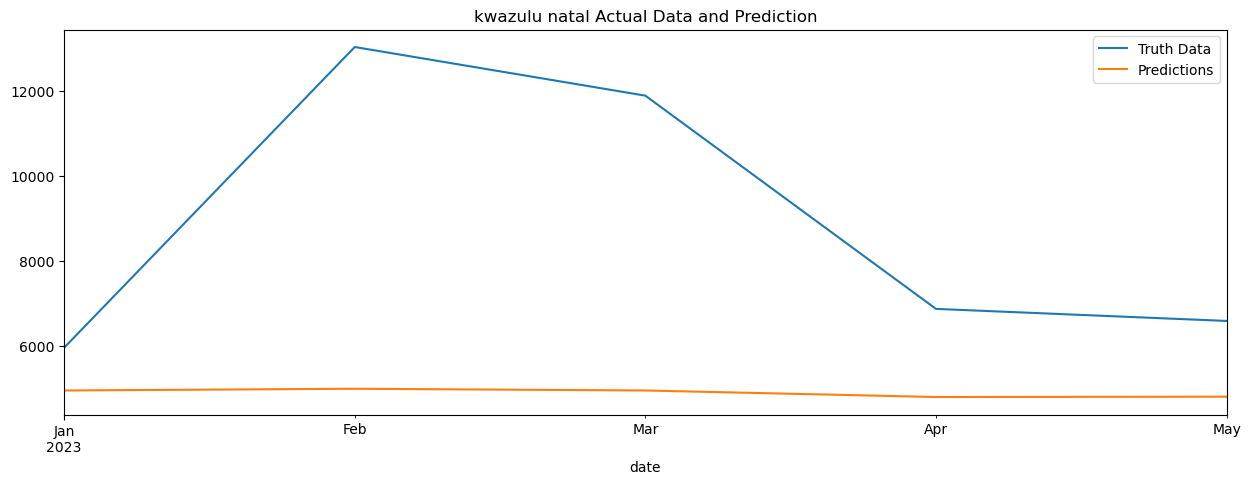

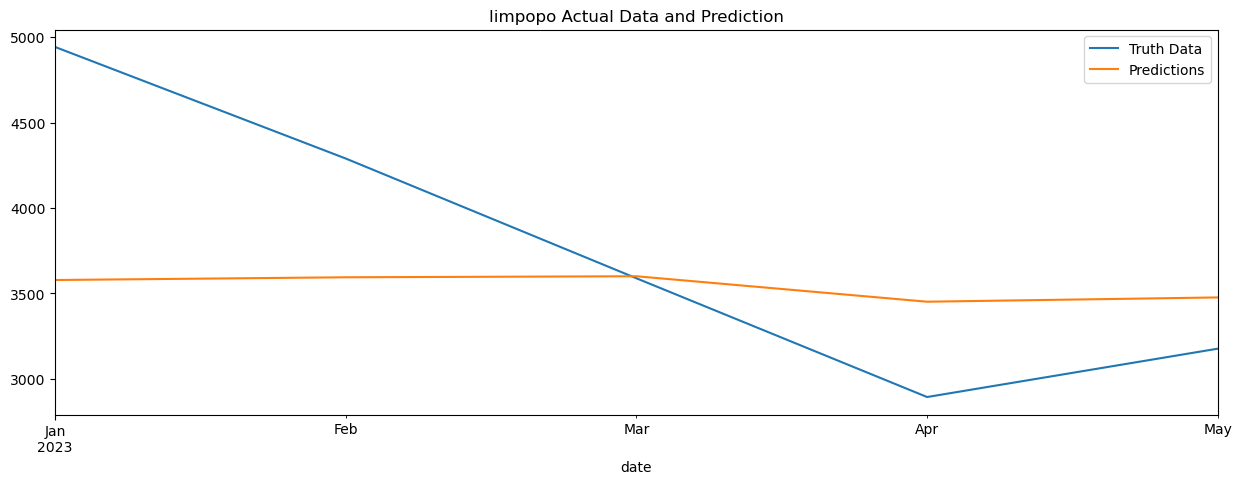

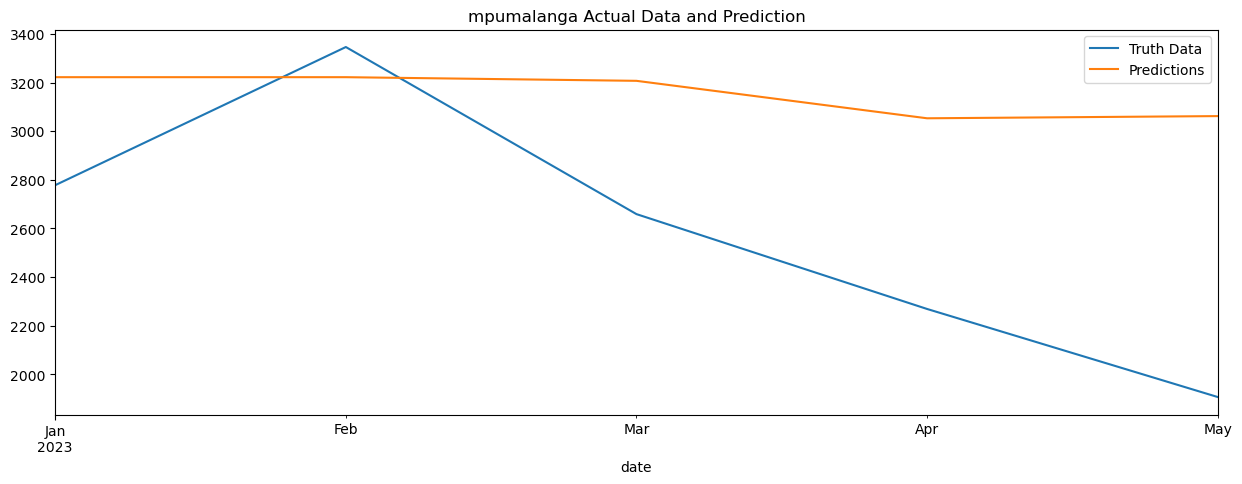

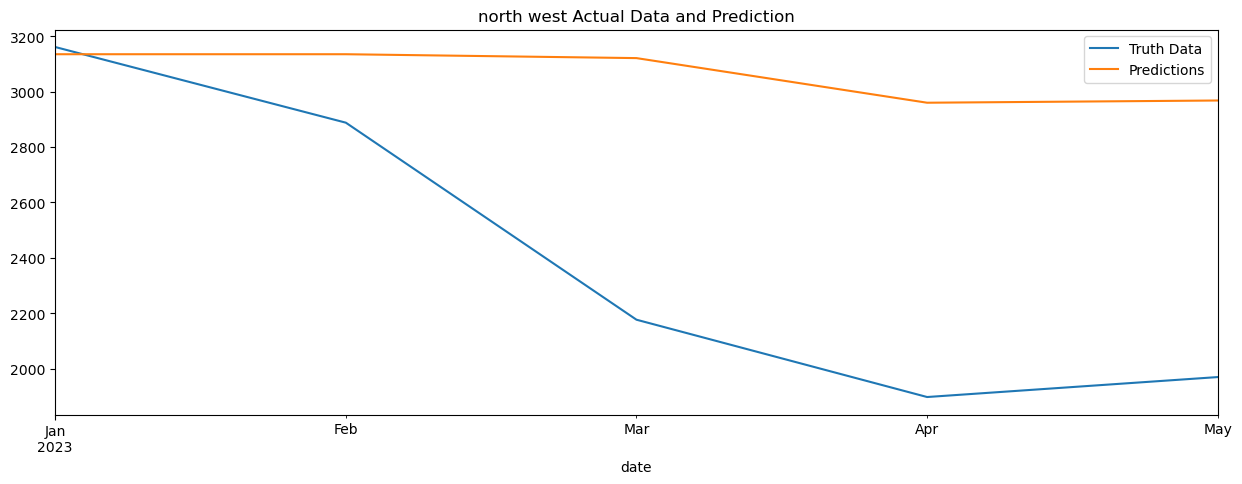

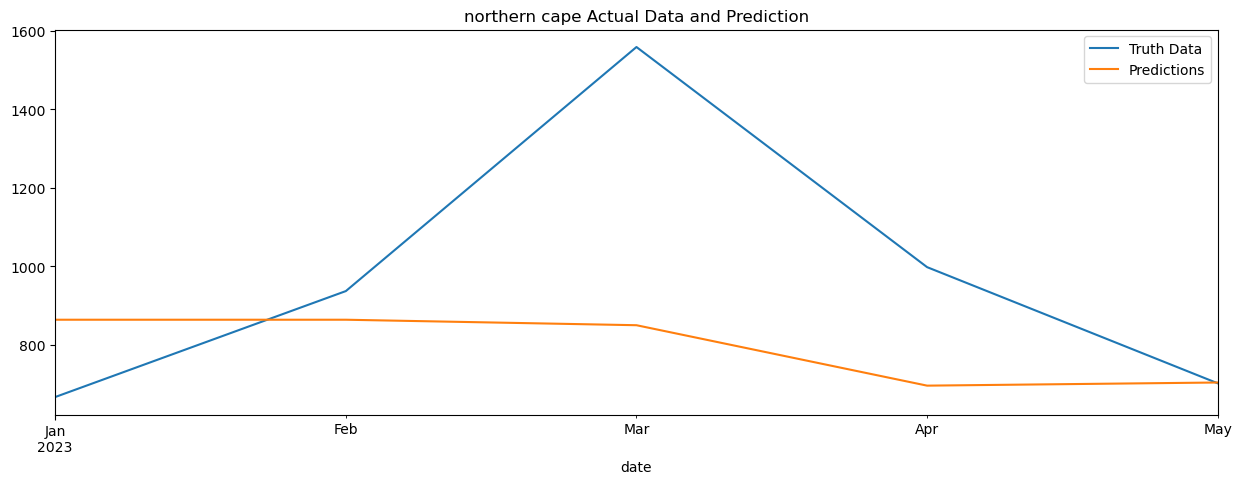

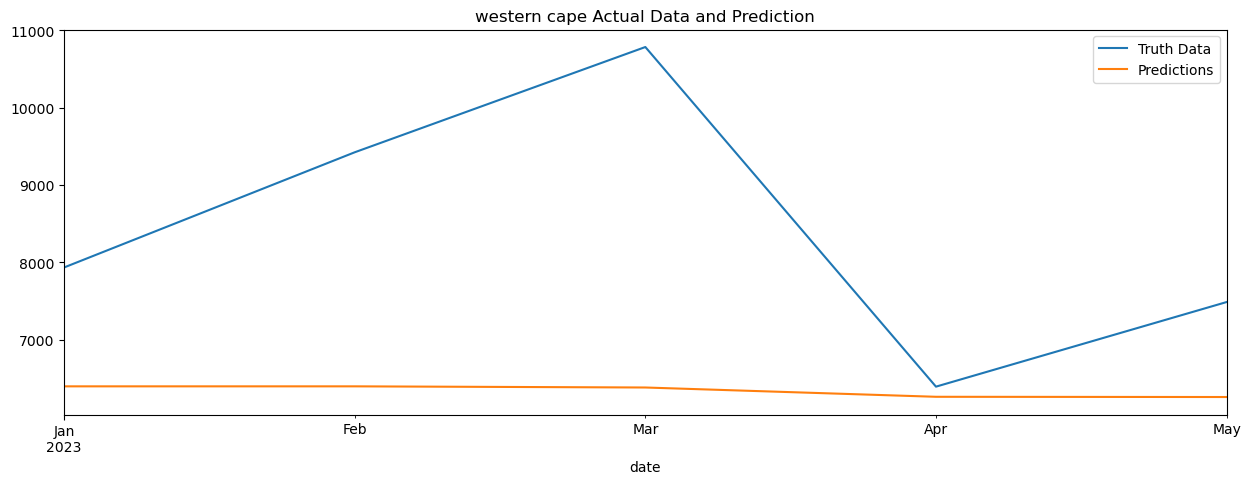

In [16]:
#Plot selected predictions
plot_predictions(df_preds)

### Create linear regression model

In [17]:
def fit_lin_regression(X_train: pd.DataFrame,
                        y_train: pd.DataFrame,
                        X_test: pd.DataFrame,
                        y_test: pd.DataFrame) -> GridSearchCV:
    """
    Fit the linear regression model on the time series data.
    """
    # Initialize a Linear Regression model
    lin_model = LinearRegression()

    # Train the model on the training data
    lin_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = lin_model.predict(X_test)

    # Evaluate the model by calculating RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Root Mean Squared Error (RMSE) on test data: ", rmse)
    
    return lin_model

lin_model = fit_lin_regression(X_train=X_train, 
                                   y_train=y_train, 
                                   X_test=X_test, 
                                   y_test=y_test)

Root Mean Squared Error (RMSE) on test data:  0.791595574159788


In [18]:
#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(lin_model, scaler_y, X_test, df_test, columns_to_keep) 

 
 
Below are plots illustrating predicted vs actual signups.


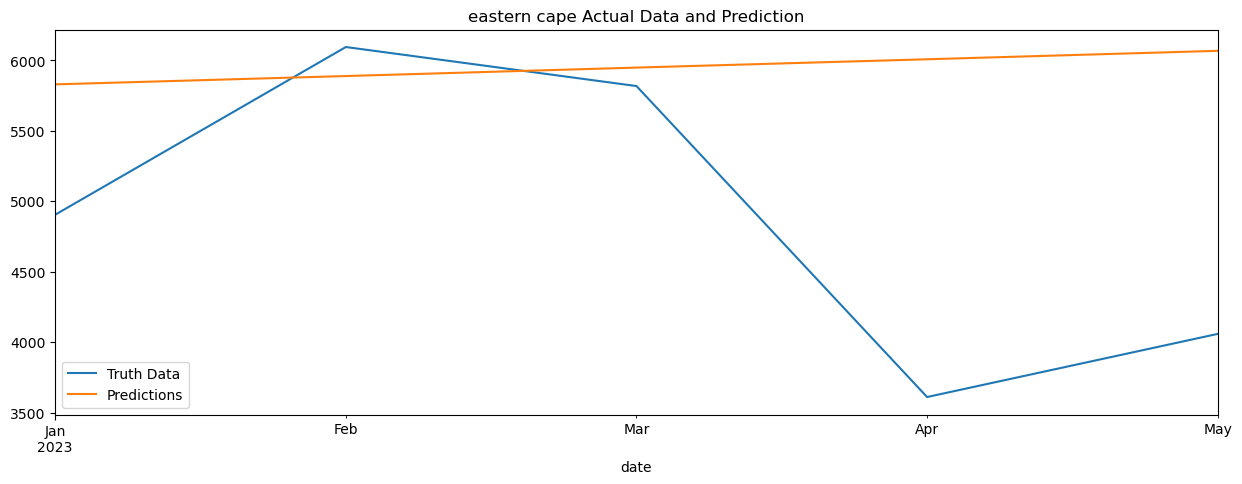

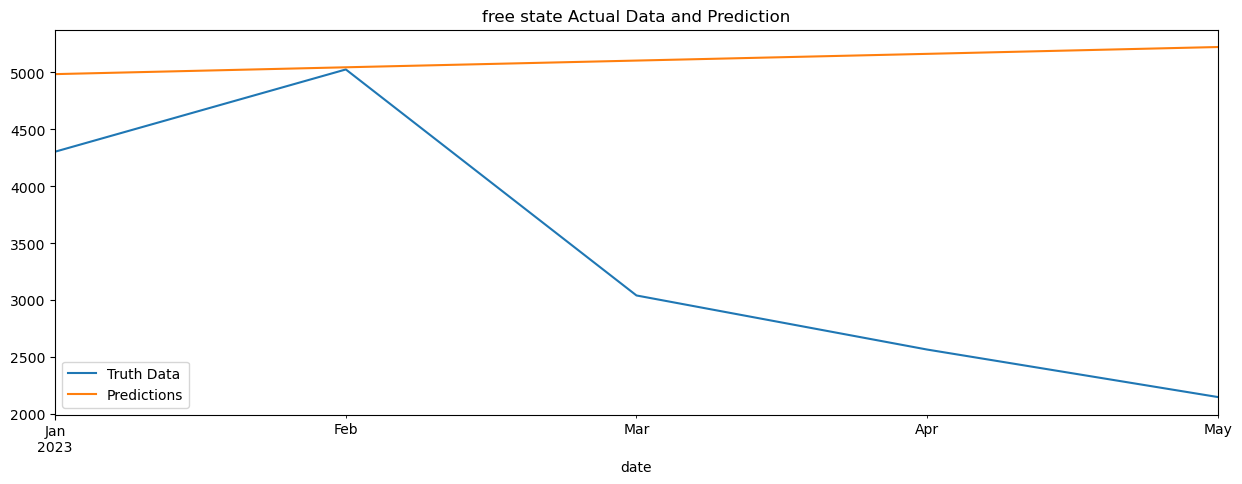

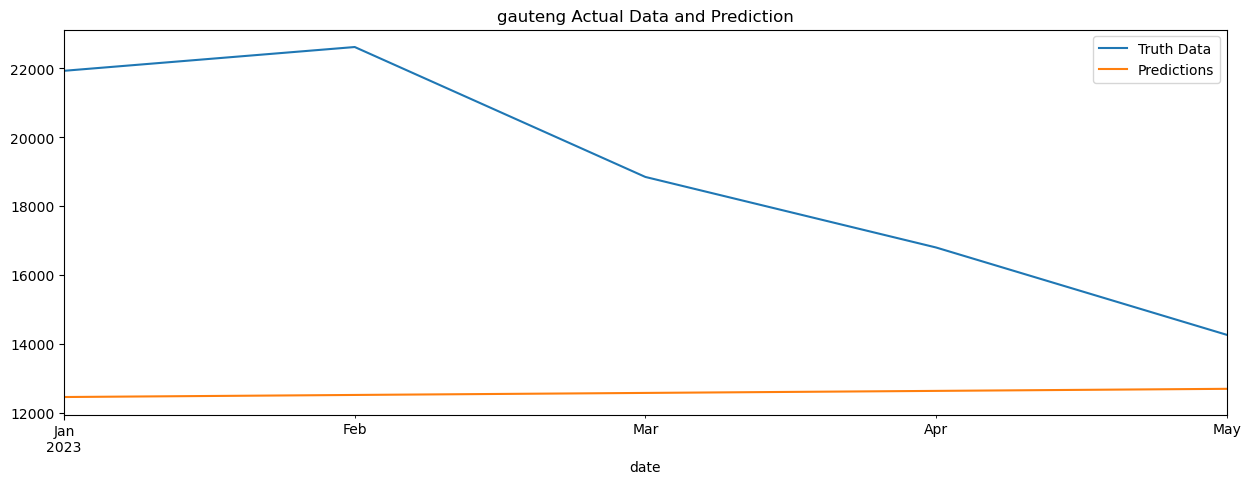

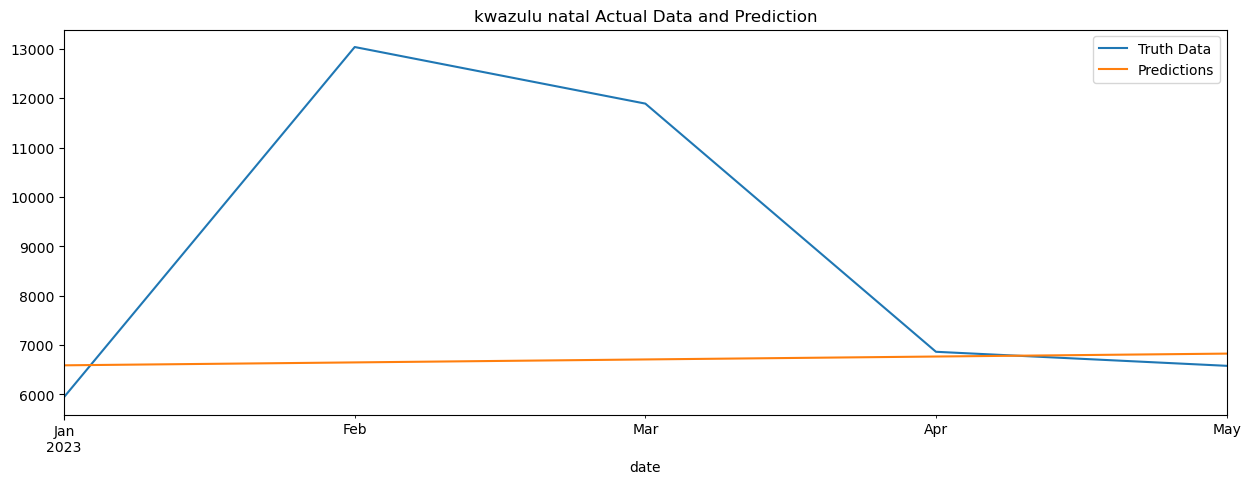

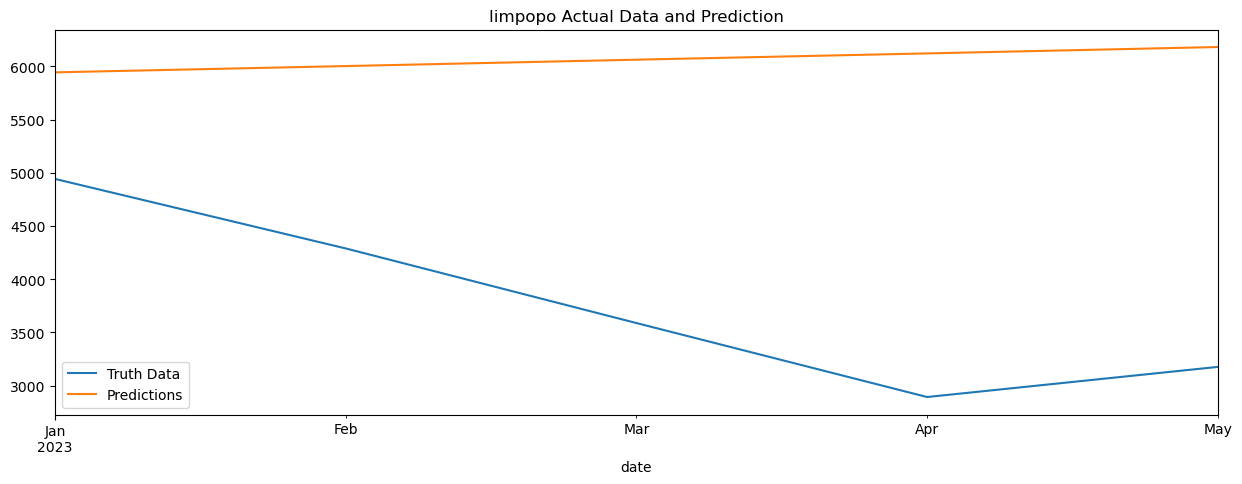

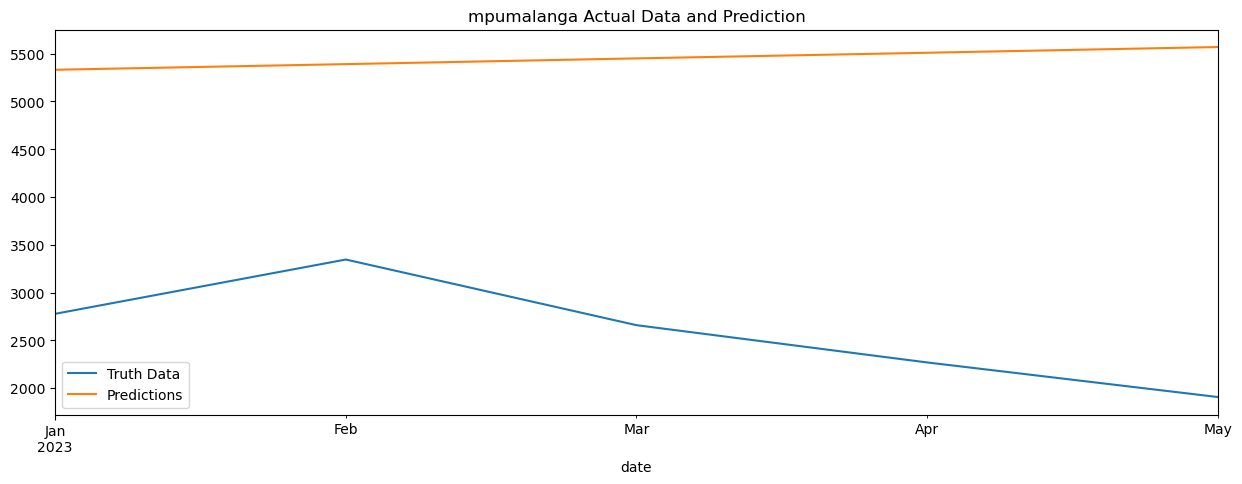

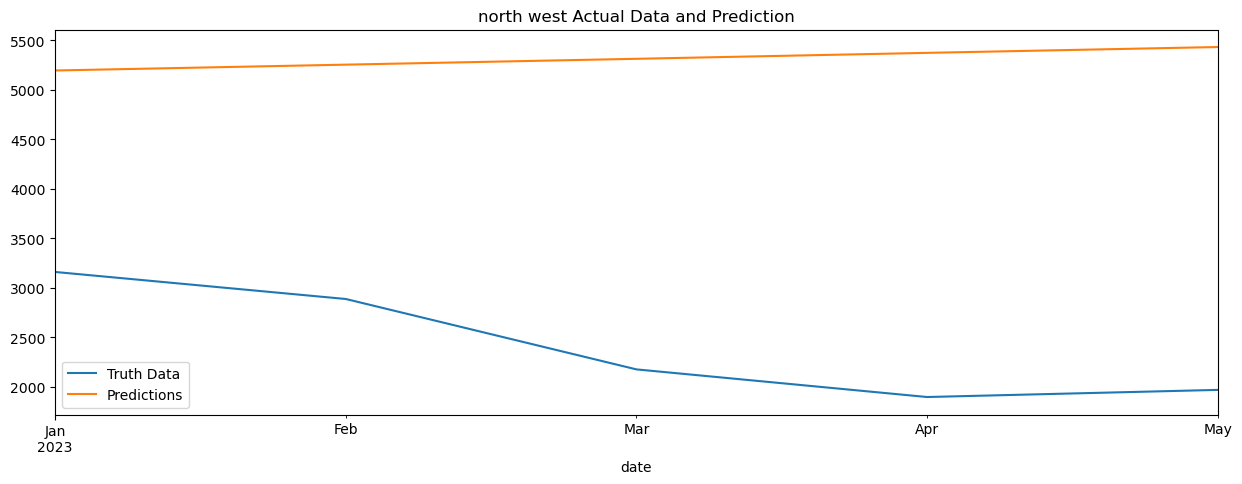

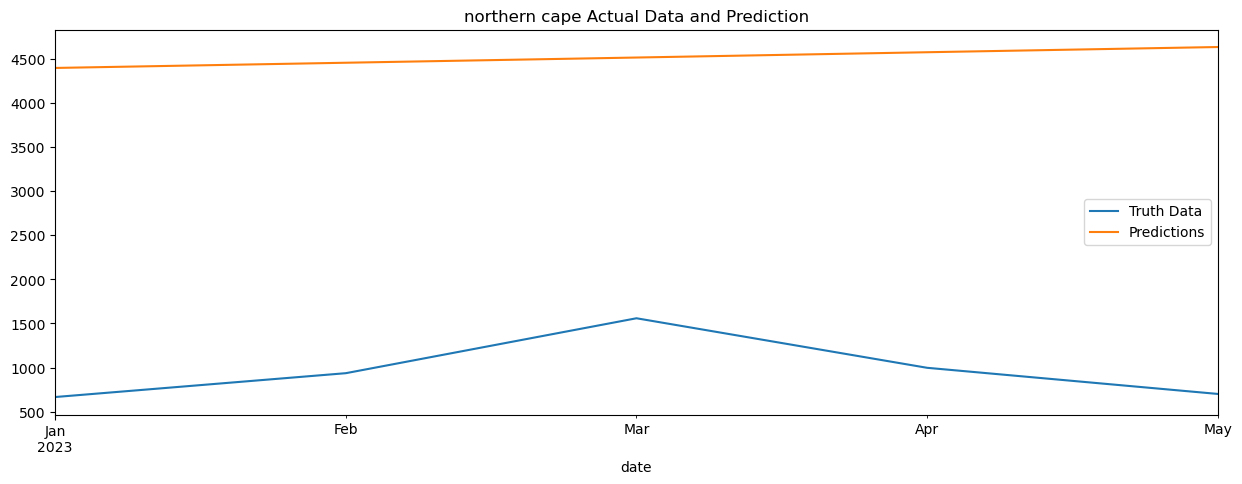

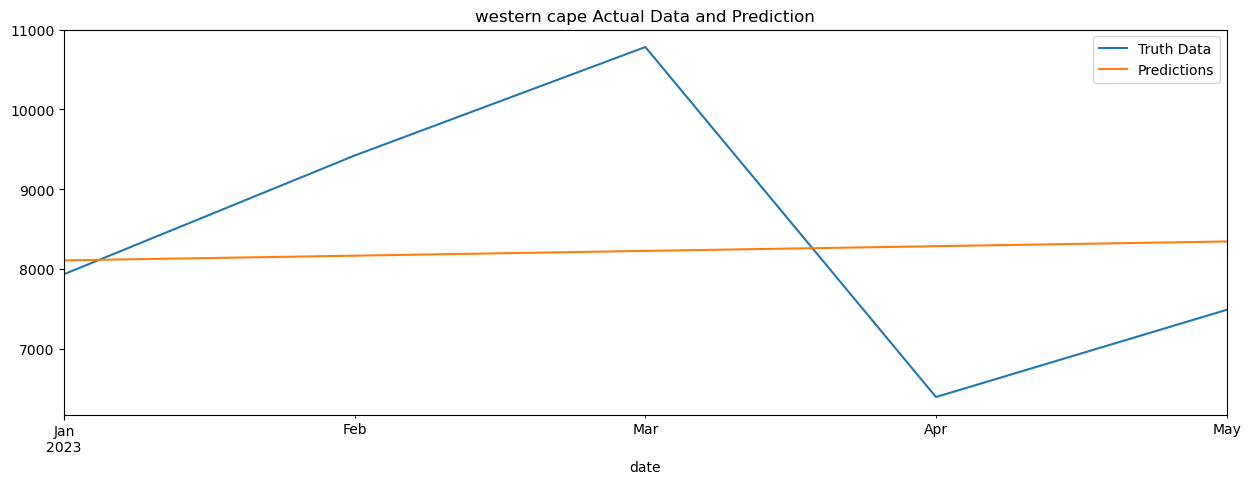

In [19]:
#Plot selected predictions
plot_predictions(df_preds)

### Create lstm model 1 layer

In [20]:
def prep_data_lstm(X_train: pd.DataFrame,
    y_train: np.array,
    X_test: pd.DataFrame,
    y_test: np.array) -> tuple[np.array, np.array, np.array, np.array]:
    """
    Prepare data for the lstm models
    """
    # Convert DataFrame to NumPy arrays
    X_train_lstm = X_train.values
    X_test_lstm = X_test.values

    # Reshape the features for LSTM [samples, time steps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

    # Reshape the target variables
    y_train_lstm = y_train.reshape((y_train.shape[0], 1))
    y_test_lstm = y_test.reshape((y_test.shape[0], 1))
    
    return X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm

X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = prep_data_lstm(X_train, y_train, X_test, y_test)

In [21]:
def fit_lstm_1_layer(
    X_train_lstm: pd.DataFrame,
    y_train_lstm: np.array,
    X_test_lstm: pd.DataFrame,
    y_test_lstm: np.array) -> Sequential:
    """
    Fit a one layer lstm model on the time series data.
    """
    # define the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')

    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=1, verbose=2, shuffle=False)

    loss = lstm_model.evaluate(X_test_lstm, y_test_lstm)
    rmse = rmse = np.sqrt(loss)
    print("Test Loss (rmse):", rmse)
    
    return lstm_model

lstm_model = fit_lstm_1_layer(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

2023-06-07 12:07:11.925153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 12:07:11.925837: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
540/540 - 2s - loss: 0.7505 - 2s/epoch - 4ms/step
Epoch 2/50
540/540 - 1s - loss: 0.5586 - 1s/epoch - 3ms/step
Epoch 3/50
540/540 - 1s - loss: 0.4042 - 1s/epoch - 2ms/step
Epoch 4/50
540/540 - 1s - loss: 0.3201 - 1s/epoch - 2ms/step
Epoch 5/50
540/540 - 1s - loss: 0.2831 - 1s/epoch - 3ms/step
Epoch 6/50
540/540 - 1s - loss: 0.2605 - 1s/epoch - 2ms/step
Epoch 7/50
540/540 - 2s - loss: 0.2429 - 2s/epoch - 3ms/step
Epoch 8/50
540/540 - 1s - loss: 0.2283 - 1s/epoch - 2ms/step
Epoch 9/50
540/540 - 1s - loss: 0.2167 - 1s/epoch - 2ms/step
Epoch 10/50
540/540 - 1s - loss: 0.2084 - 1s/epoch - 2ms/step
Epoch 11/50
540/540 - 1s - loss: 0.2031 - 1s/epoch - 2ms/step
Epoch 12/50
540/540 - 1s - loss: 0.1998 - 1s/epoch - 2ms/step
Epoch 13/50
540/540 - 1s - loss: 0.1977 - 1s/epoch - 2ms/step
Epoch 14/50
540/540 - 1s - loss: 0.1961 - 1s/epoch - 2ms/step
Epoch 15/50
540/540 - 1s - loss: 0.1946 - 1s/epoch - 2ms/step
Epoch 16/50
540/540 - 1s - loss: 0.1933 - 1s/epoch - 2ms/step
Epoch 17/50
540/5

In [22]:
#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(lstm_model, scaler_y, X_test_lstm, df_test, columns_to_keep) 

2/2 [==============================] - 0s 11ms/step


 
 
Below are plots illustrating predicted vs actual signups.


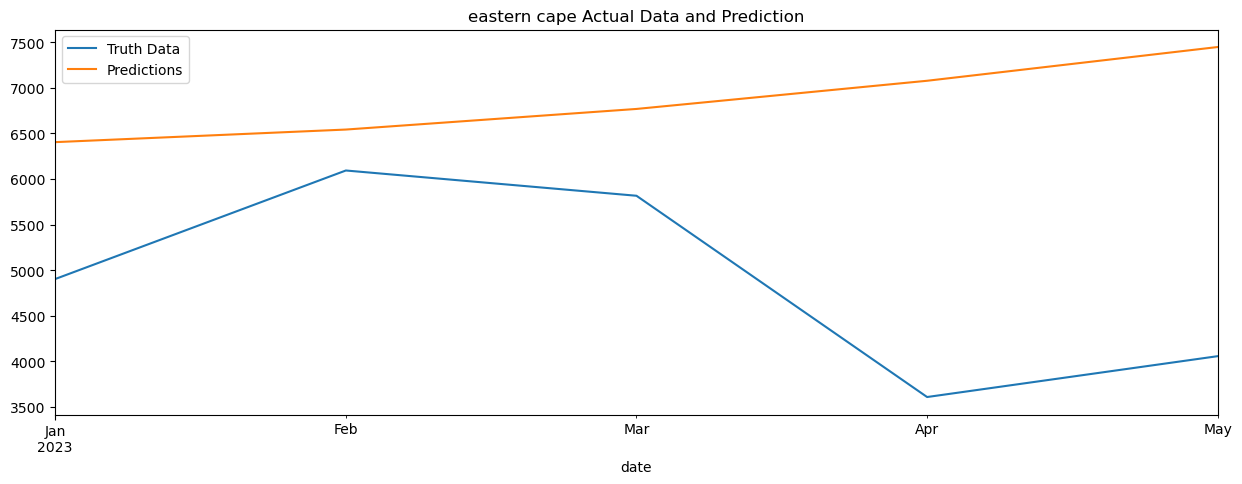

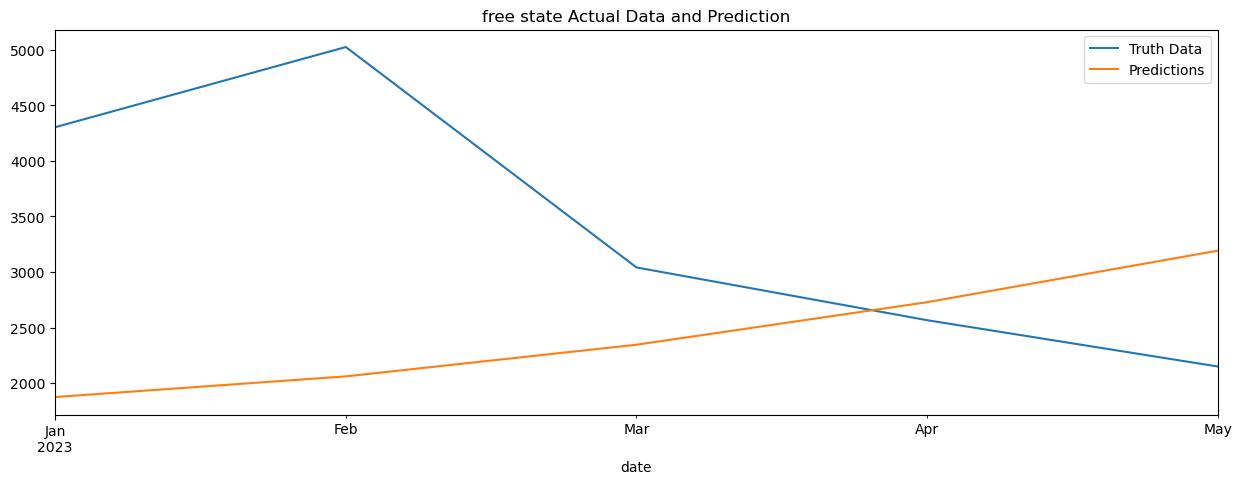

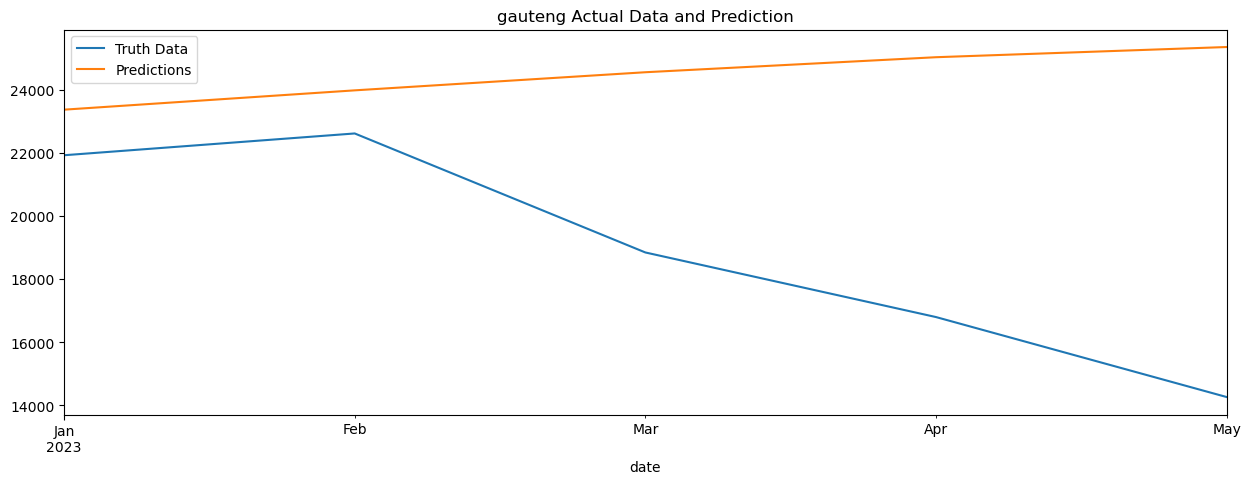

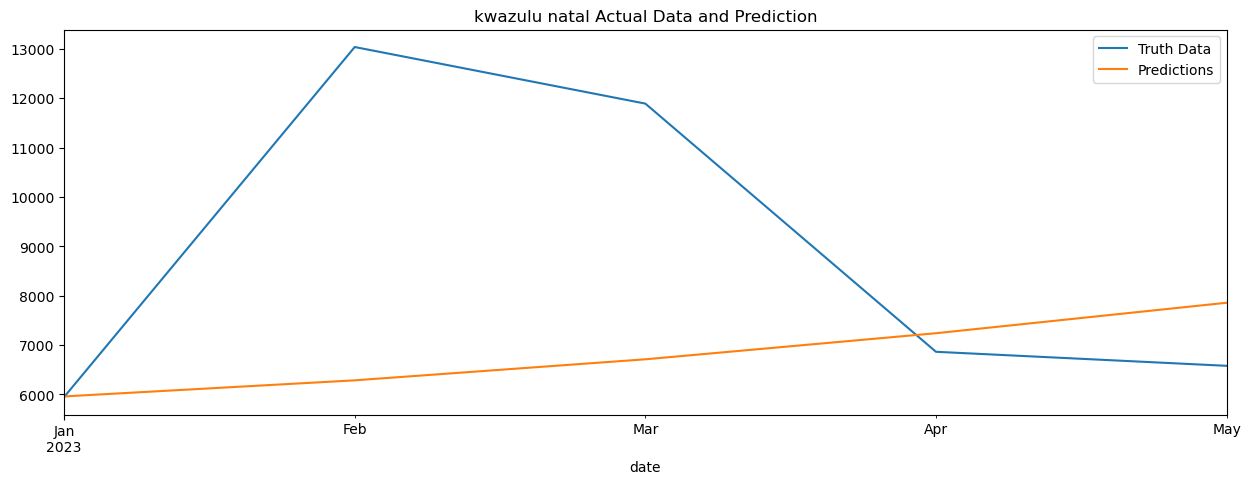

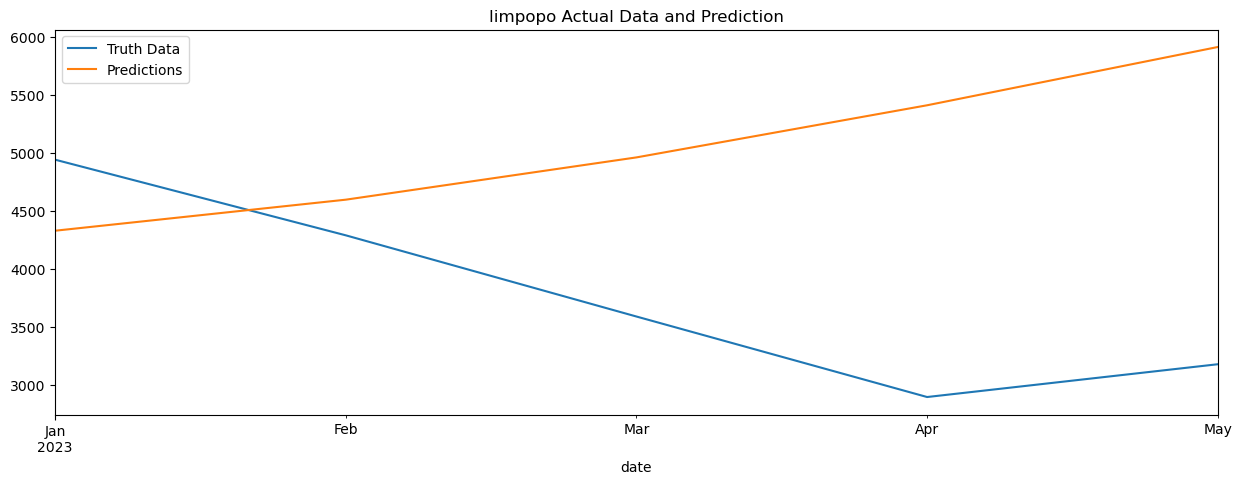

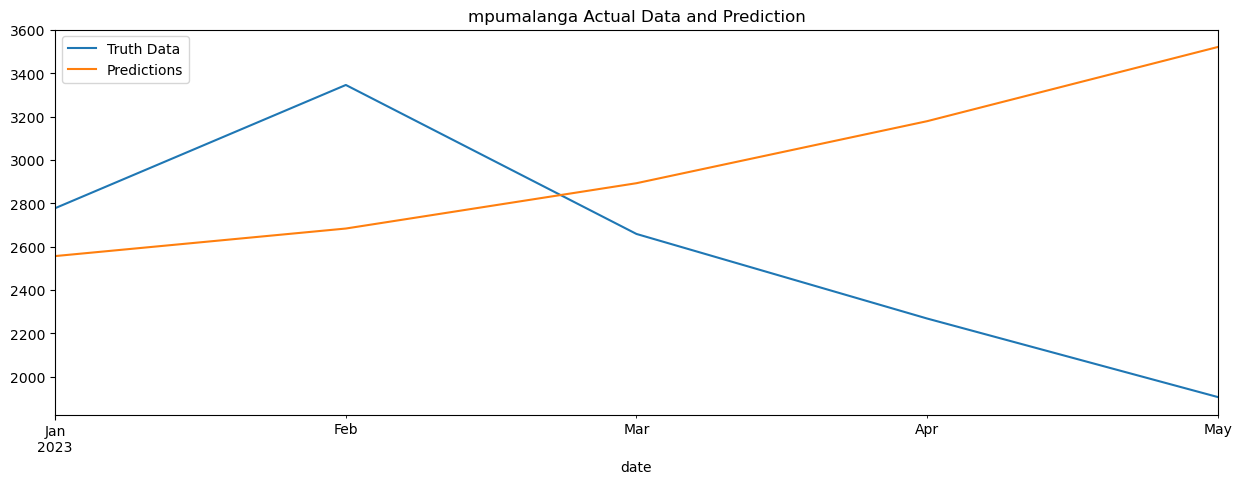

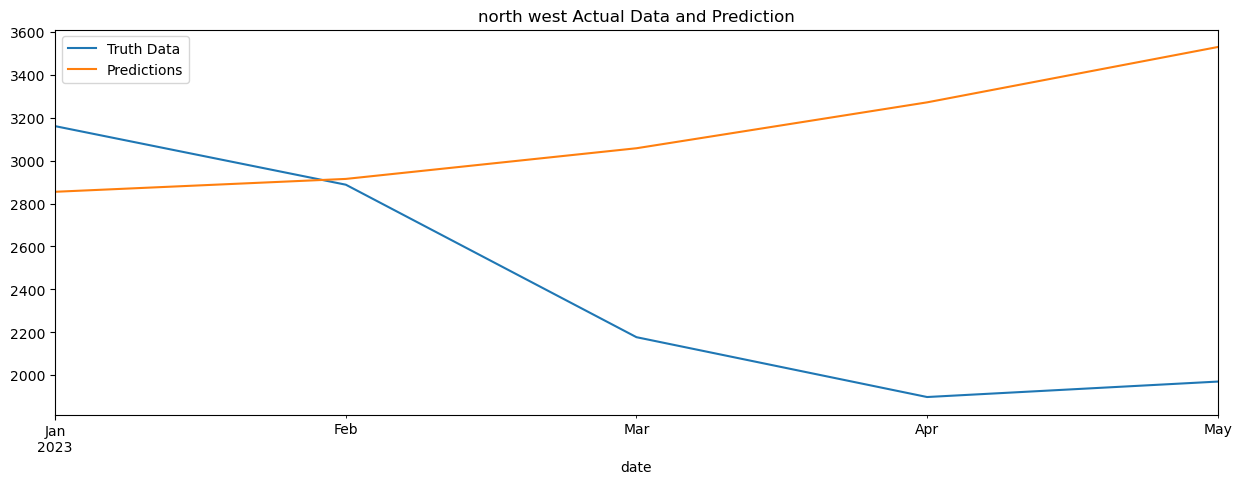

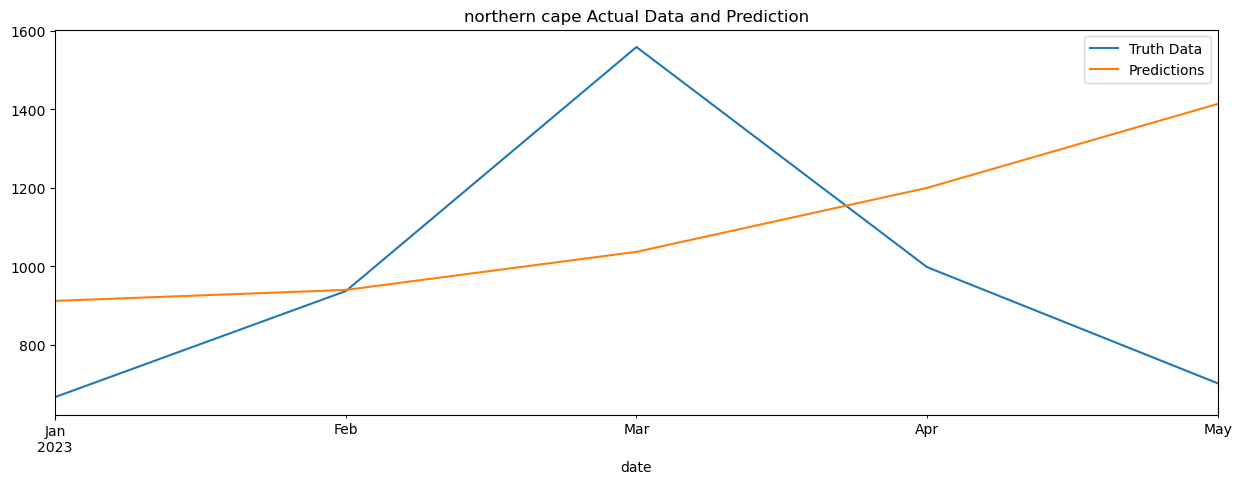

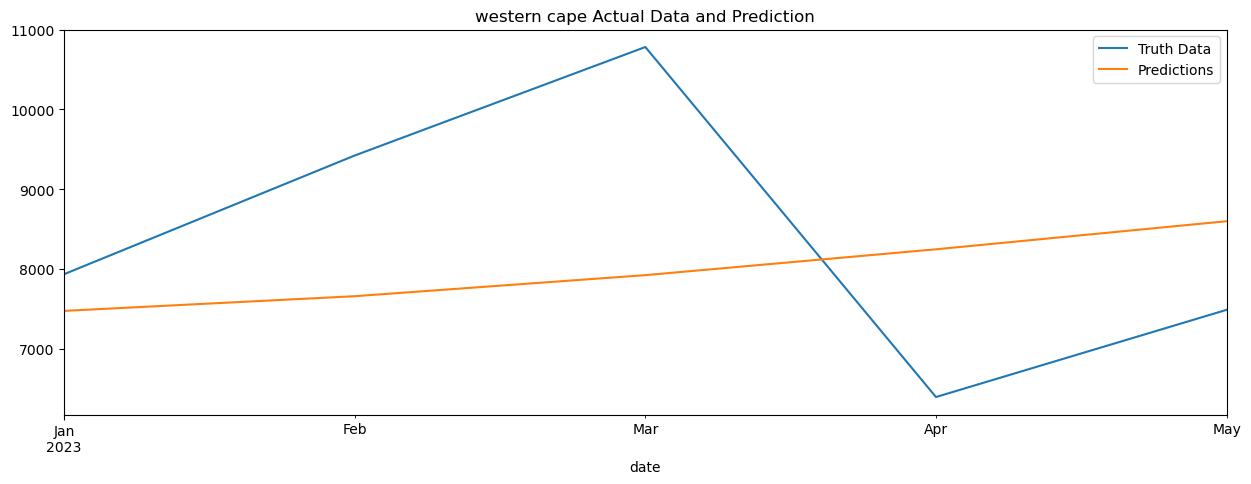

In [23]:
#Plot selected predictions
plot_predictions(df_preds)

### LSTM model with 2 layers

In [24]:
def fit_lstm_2_layer(
    X_train_lstm: pd.DataFrame,
    y_train_lstm: np.array,
    X_test_lstm: pd.DataFrame,
    y_test_lstm: np.array) -> Sequential:
    """
    Fit a two layer lstm model on the time series data.
    """
    # Altered LSTM model
    lstm_model_2 = Sequential()
    lstm_model_2.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    lstm_model_2.add(LSTM(50))
    lstm_model_2.add(Dense(1))
    lstm_model_2.compile(loss='mean_squared_error', optimizer='adam')

    lstm_model_2.fit(X_train_lstm, y_train, epochs=50, batch_size=1, verbose=2, shuffle=False)

    loss = lstm_model_2.evaluate(X_test_lstm, y_test_lstm)
    rmse = rmse = np.sqrt(loss)
    print("Test Loss (rmse):", rmse)

    return lstm_model_2

lstm_model_2 = fit_lstm_2_layer(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

Epoch 1/50
540/540 - 3s - loss: 0.7256 - 3s/epoch - 6ms/step
Epoch 2/50
540/540 - 1s - loss: 0.3864 - 1s/epoch - 3ms/step
Epoch 3/50
540/540 - 1s - loss: 0.2944 - 1s/epoch - 3ms/step
Epoch 4/50
540/540 - 1s - loss: 0.2640 - 1s/epoch - 3ms/step
Epoch 5/50
540/540 - 1s - loss: 0.2468 - 1s/epoch - 3ms/step
Epoch 6/50
540/540 - 1s - loss: 0.2340 - 1s/epoch - 3ms/step
Epoch 7/50
540/540 - 1s - loss: 0.2243 - 1s/epoch - 3ms/step
Epoch 8/50
540/540 - 1s - loss: 0.2173 - 1s/epoch - 2ms/step
Epoch 9/50
540/540 - 1s - loss: 0.2119 - 1s/epoch - 3ms/step
Epoch 10/50
540/540 - 2s - loss: 0.2074 - 2s/epoch - 3ms/step
Epoch 11/50
540/540 - 2s - loss: 0.2036 - 2s/epoch - 3ms/step
Epoch 12/50
540/540 - 2s - loss: 0.2003 - 2s/epoch - 3ms/step
Epoch 13/50
540/540 - 2s - loss: 0.1974 - 2s/epoch - 3ms/step
Epoch 14/50
540/540 - 1s - loss: 0.1947 - 1s/epoch - 3ms/step
Epoch 15/50
540/540 - 2s - loss: 0.1921 - 2s/epoch - 3ms/step
Epoch 16/50
540/540 - 1s - loss: 0.1895 - 1s/epoch - 3ms/step
Epoch 17/50
540/5

In [25]:
#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(lstm_model_2, scaler_y, X_test_lstm, df_test, columns_to_keep) 

2/2 [==============================] - 1s 15ms/step


 
 
Below are plots illustrating predicted vs actual signups.


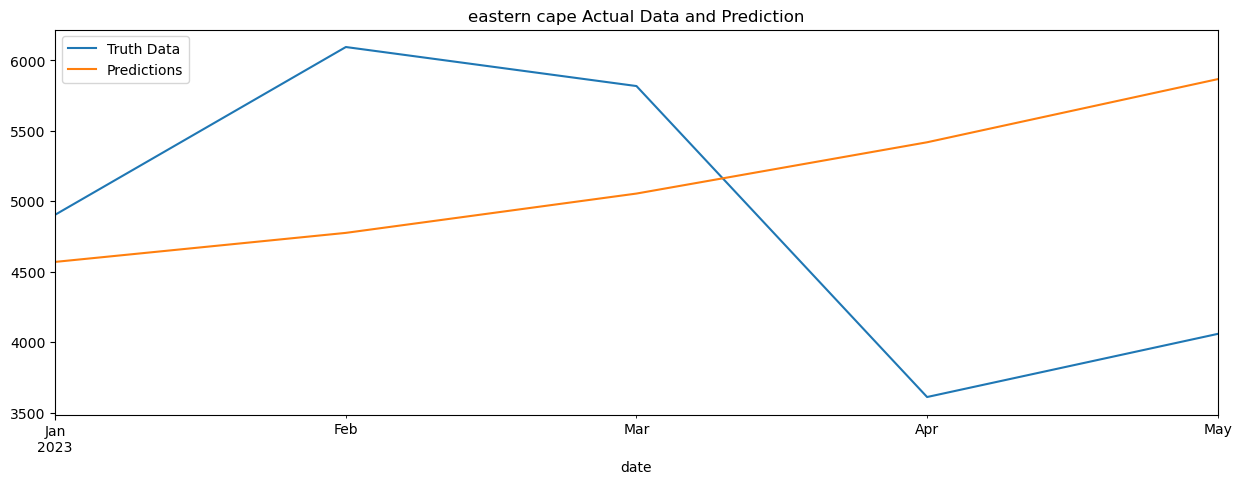

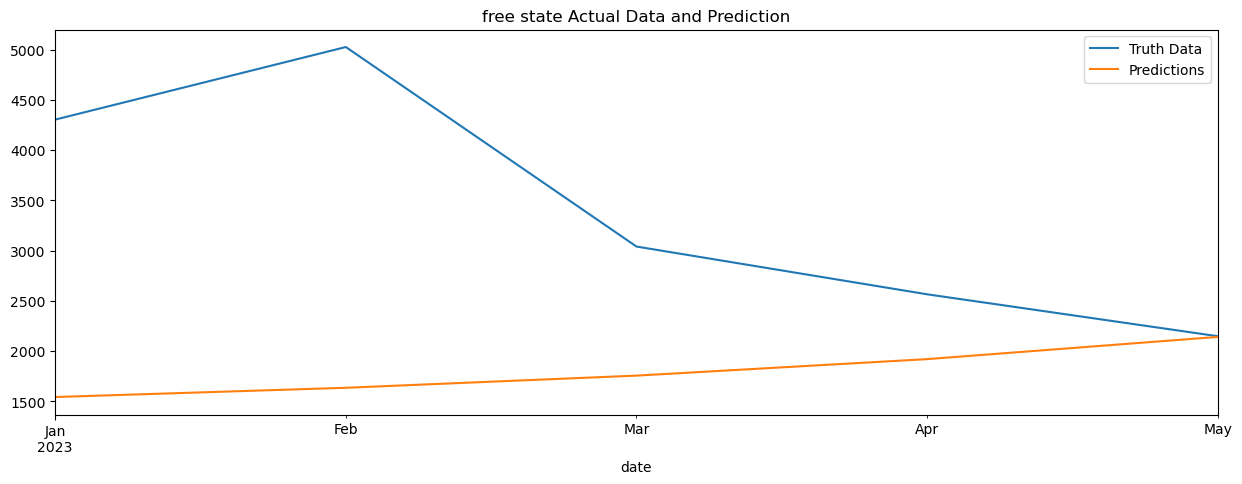

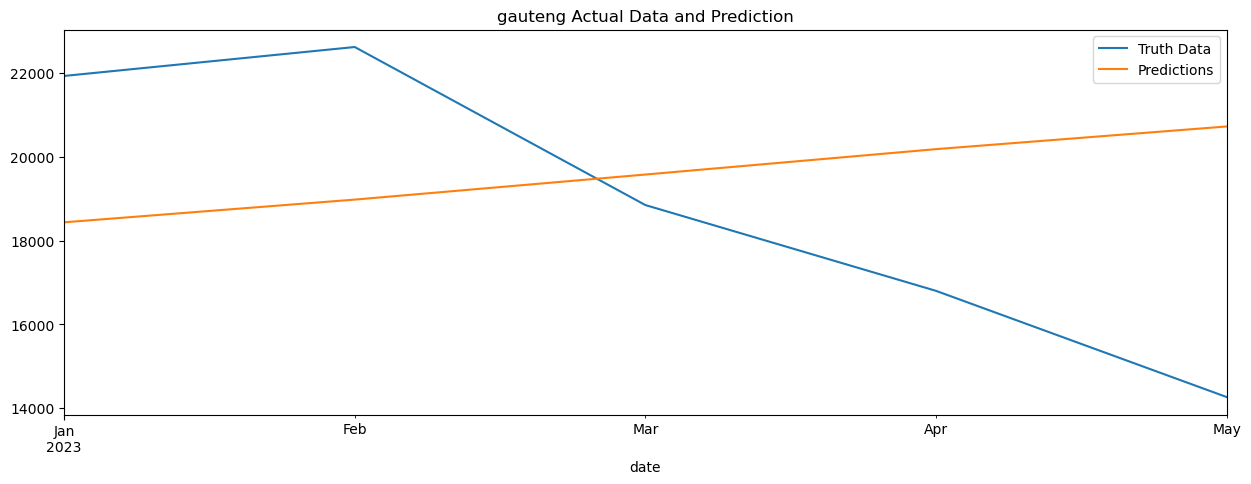

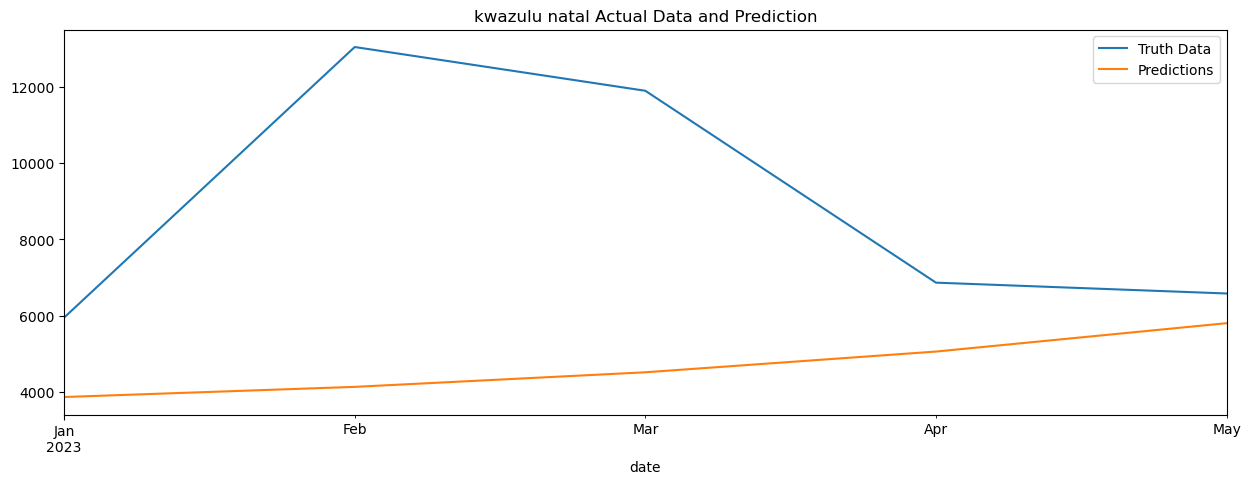

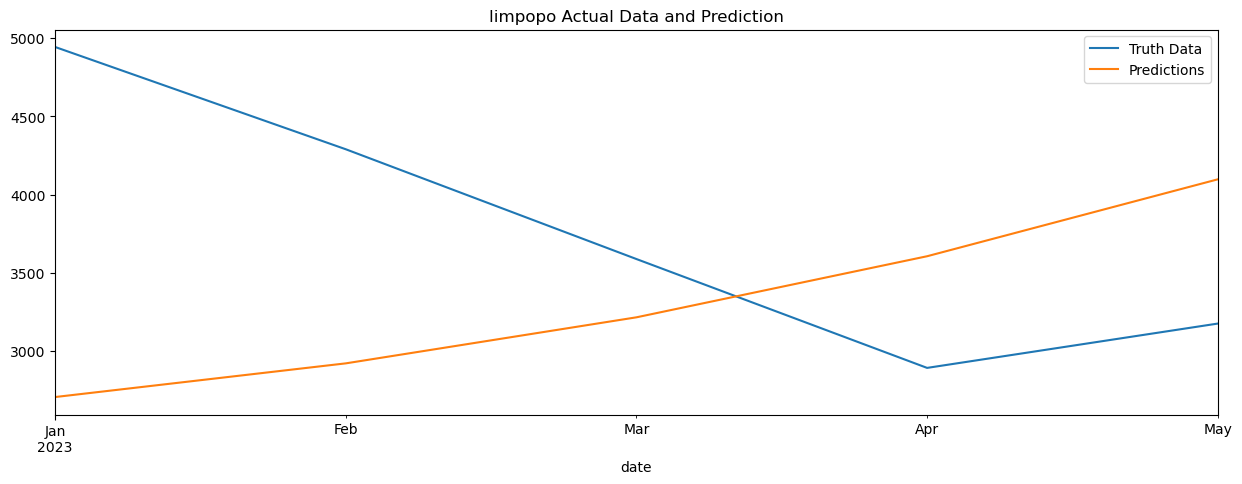

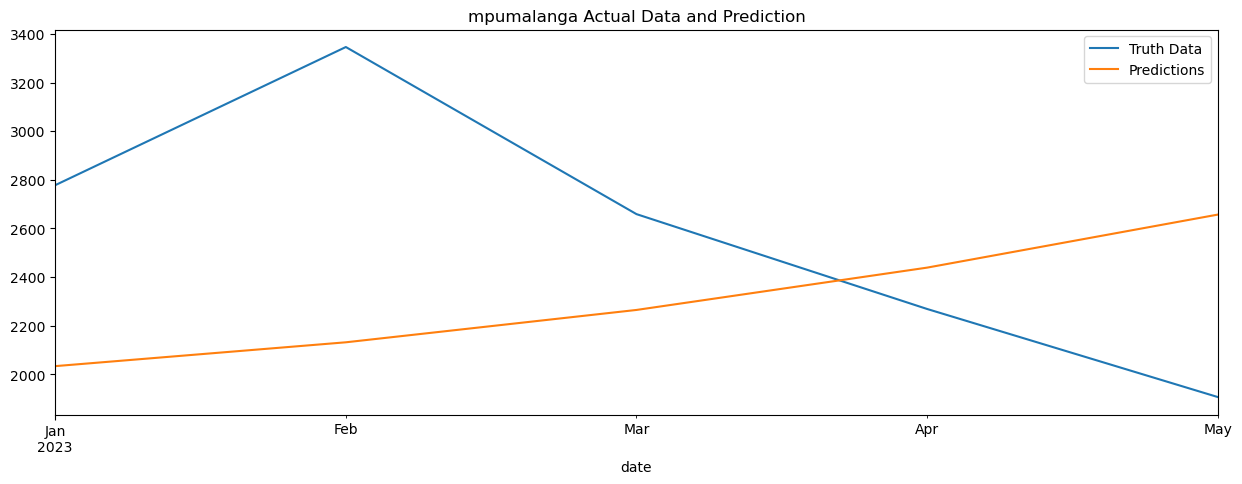

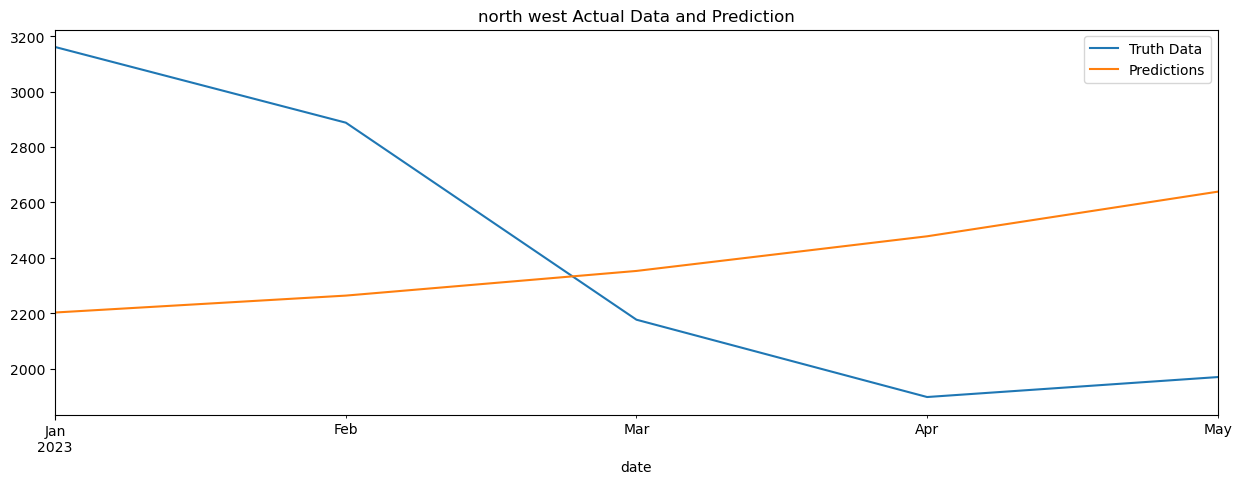

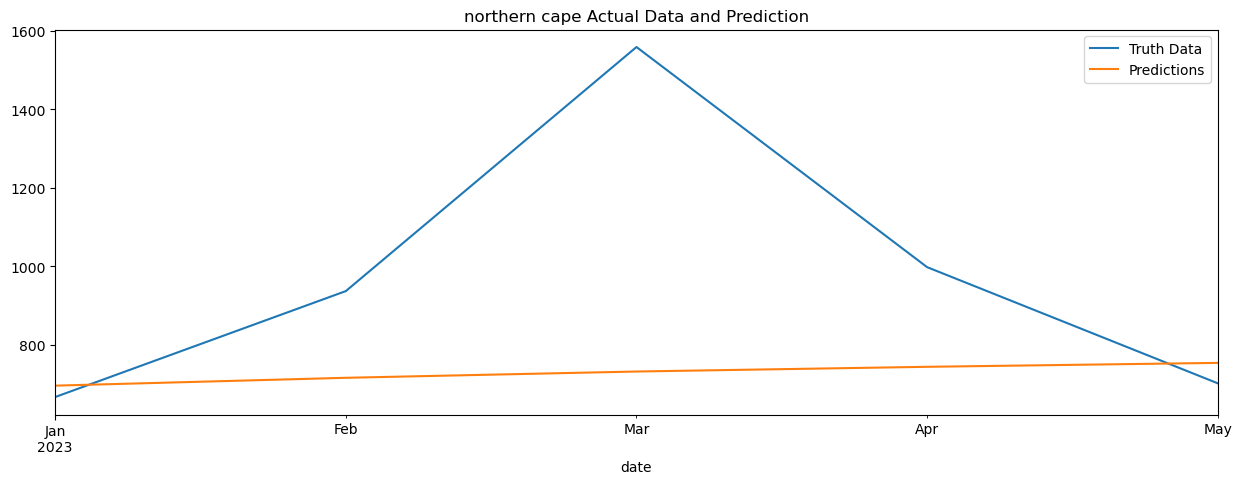

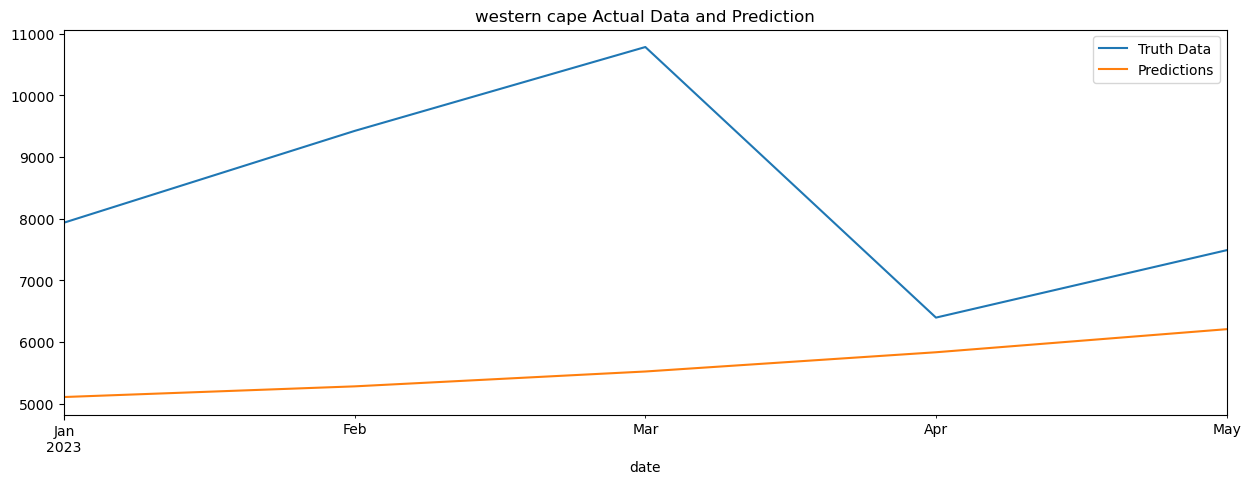

In [26]:
#Plot selected predictions
plot_predictions(df_preds)

### LSTM model with 3 layers

In [27]:
def fit_lstm_3_layer(
    X_train_lstm: pd.DataFrame,
    y_train_lstm: np.array,
    X_test_lstm: pd.DataFrame,
    y_test_lstm: np.array) -> Sequential:
    """
    Fit a three layer lstm model on the time series data.
    """
    # Altered LSTM model
    lstm_model_3 = Sequential()
    lstm_model_3.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    lstm_model_3.add(LSTM(50, return_sequences=True))
    lstm_model_3.add(LSTM(50))
    lstm_model_3.add(Dense(1))
    lstm_model_3.compile(loss='mean_squared_error', optimizer='adam')

    lstm_model_3.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=1, verbose=2, shuffle=False)

    loss = lstm_model_3.evaluate(X_test_lstm, y_test_lstm)
    rmse = rmse = np.sqrt(loss)
    print("Test Loss (rmse):", rmse)
    
    return lstm_model_3

lstm_model_3 = fit_lstm_3_layer(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

Epoch 1/50
540/540 - 4s - loss: 0.7616 - 4s/epoch - 8ms/step
Epoch 2/50
540/540 - 2s - loss: 0.3317 - 2s/epoch - 4ms/step
Epoch 3/50
540/540 - 2s - loss: 0.2931 - 2s/epoch - 3ms/step
Epoch 4/50
540/540 - 2s - loss: 0.2732 - 2s/epoch - 3ms/step
Epoch 5/50
540/540 - 2s - loss: 0.2663 - 2s/epoch - 3ms/step
Epoch 6/50
540/540 - 2s - loss: 0.2481 - 2s/epoch - 3ms/step
Epoch 7/50
540/540 - 2s - loss: 0.2323 - 2s/epoch - 3ms/step
Epoch 8/50
540/540 - 2s - loss: 0.2200 - 2s/epoch - 3ms/step
Epoch 9/50
540/540 - 2s - loss: 0.2091 - 2s/epoch - 3ms/step
Epoch 10/50
540/540 - 2s - loss: 0.1997 - 2s/epoch - 4ms/step
Epoch 11/50
540/540 - 2s - loss: 0.1872 - 2s/epoch - 4ms/step
Epoch 12/50
540/540 - 2s - loss: 0.1734 - 2s/epoch - 3ms/step
Epoch 13/50
540/540 - 2s - loss: 0.1638 - 2s/epoch - 4ms/step
Epoch 14/50
540/540 - 2s - loss: 0.1589 - 2s/epoch - 4ms/step
Epoch 15/50
540/540 - 2s - loss: 0.1568 - 2s/epoch - 3ms/step
Epoch 16/50
540/540 - 2s - loss: 0.1557 - 2s/epoch - 3ms/step
Epoch 17/50
540/5

In [28]:
#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(lstm_model_3, scaler_y, X_test_lstm, df_test, columns_to_keep) 

2/2 [==============================] - 1s 11ms/step


 
 
Below are plots illustrating predicted vs actual signups.


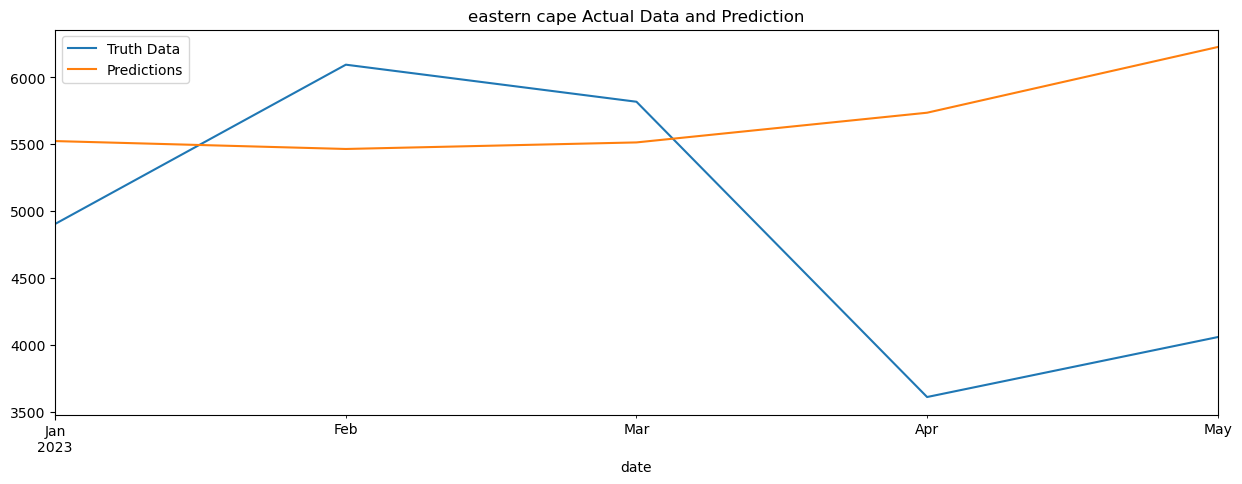

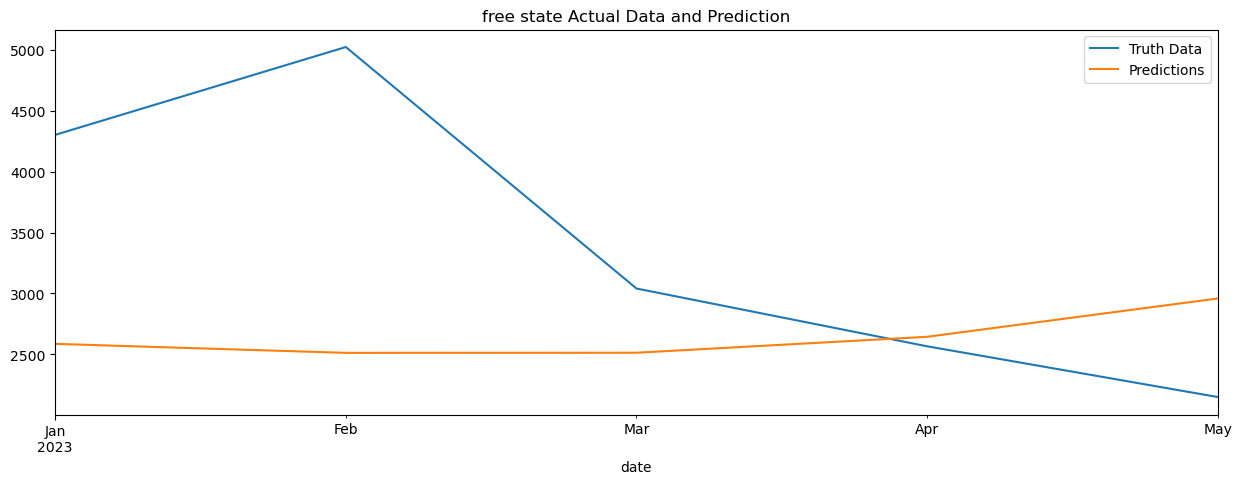

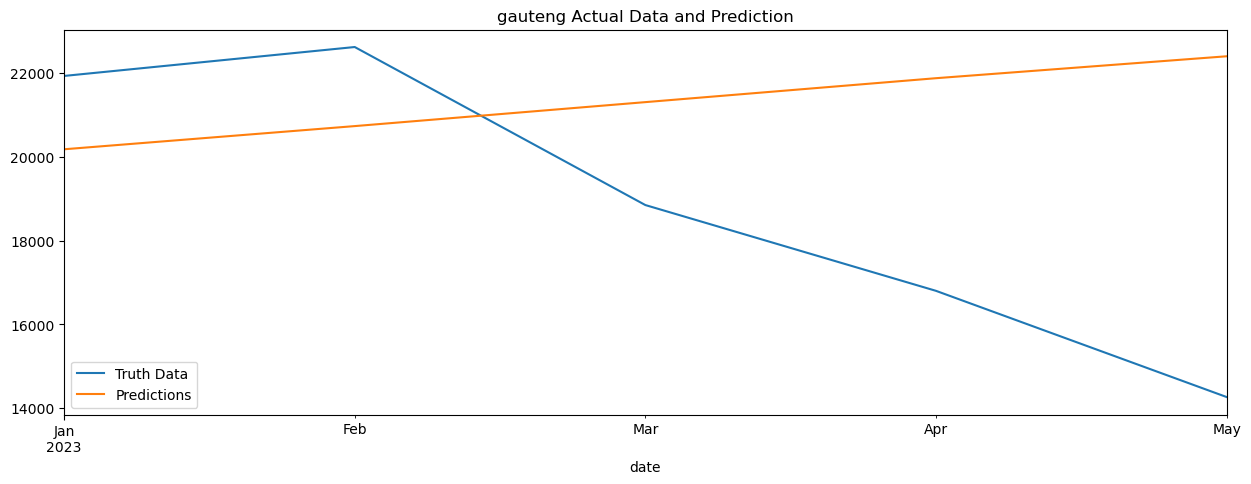

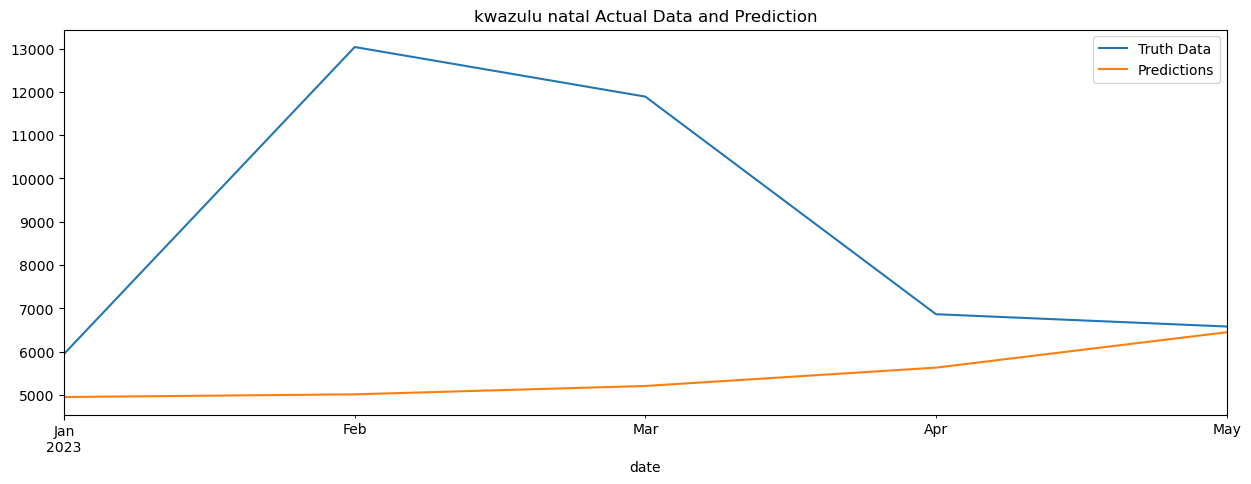

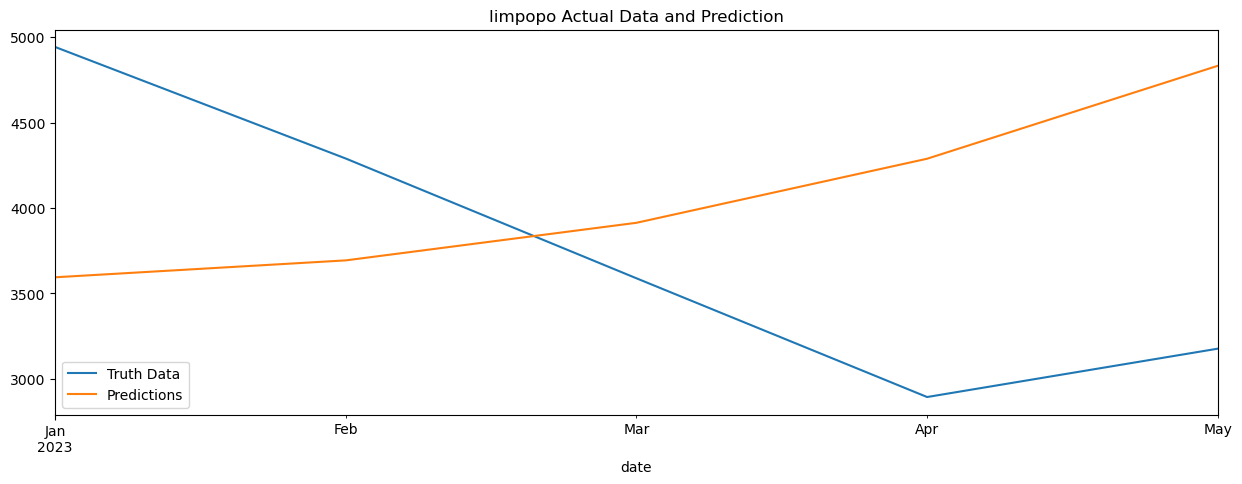

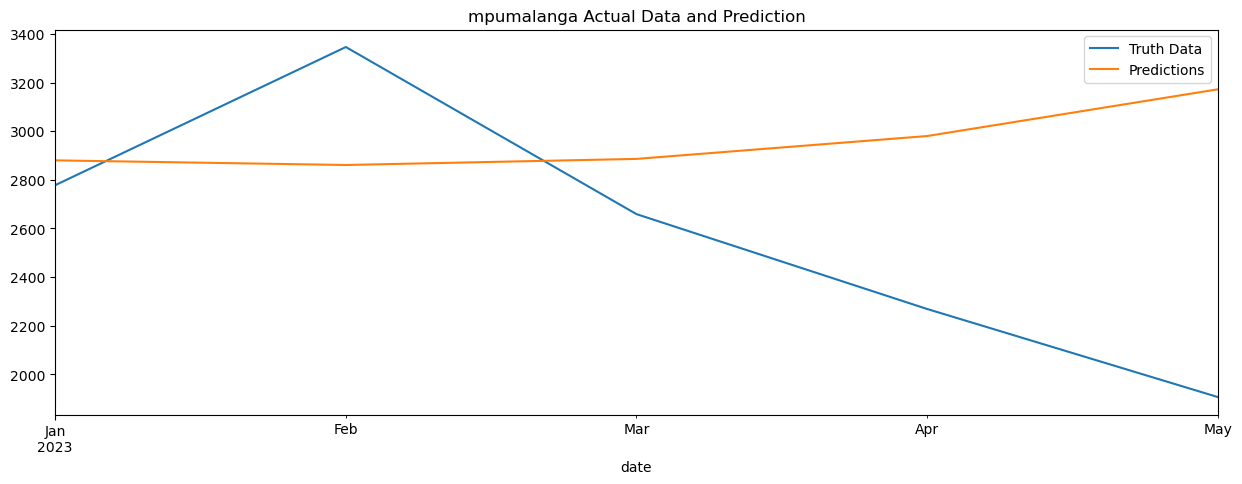

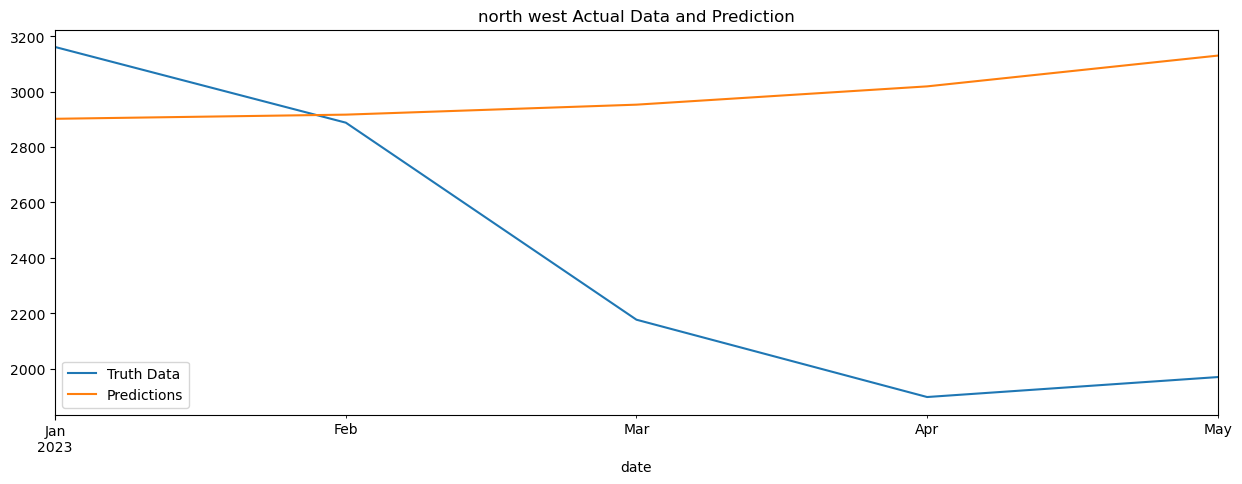

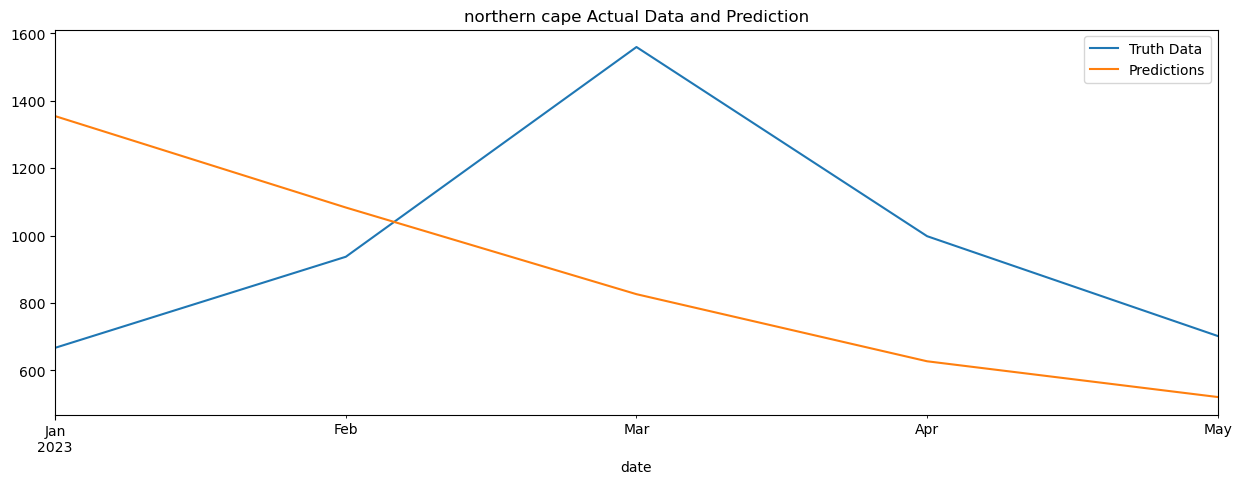

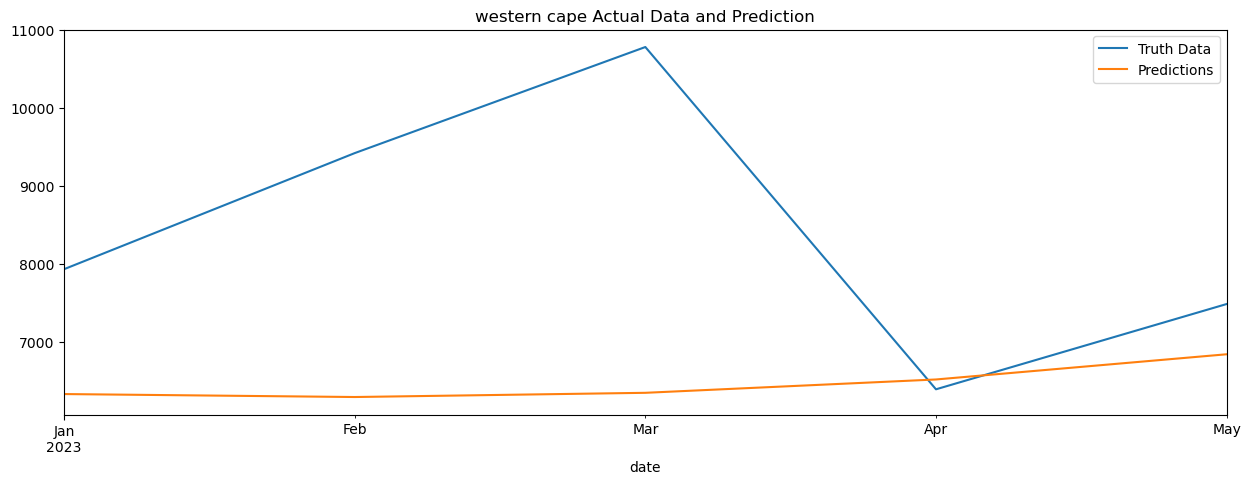

In [29]:
#Plot selected predictions
plot_predictions(df_preds)

### LSTM with 4 layers

In [30]:
def fit_lstm_4_layer(
    X_train_lstm: pd.DataFrame,
    y_train_lstm: np.array,
    X_test_lstm: pd.DataFrame,
    y_test_lstm: np.array) -> Sequential:
    """
    Fit a four layer lstm model on the time series data.
    """
    # Altered LSTM model
    lstm_model_4 = Sequential()
    lstm_model_4.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    lstm_model_4.add(LSTM(50, return_sequences=True))
    lstm_model_4.add(LSTM(50, return_sequences=True))
    lstm_model_4.add(LSTM(50))
    lstm_model_4.add(Dense(1))
    lstm_model_4.compile(loss='mean_squared_error', optimizer='adam')

    lstm_model_4.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=1, verbose=2, shuffle=False)

    loss = lstm_model_4.evaluate(X_test_lstm, y_test_lstm)
    rmse = rmse = np.sqrt(loss)
    print("Test Loss (rmse):", rmse)

    return lstm_model_4

lstm_model_4 = fit_lstm_4_layer(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

Epoch 1/50
540/540 - 5s - loss: 0.7727 - 5s/epoch - 10ms/step
Epoch 2/50
540/540 - 3s - loss: 0.2951 - 3s/epoch - 5ms/step
Epoch 3/50
540/540 - 3s - loss: 0.3036 - 3s/epoch - 5ms/step
Epoch 4/50
540/540 - 3s - loss: 0.2926 - 3s/epoch - 5ms/step
Epoch 5/50
540/540 - 3s - loss: 0.3051 - 3s/epoch - 5ms/step
Epoch 6/50
540/540 - 2s - loss: 0.2927 - 2s/epoch - 5ms/step
Epoch 7/50
540/540 - 2s - loss: 0.2682 - 2s/epoch - 5ms/step
Epoch 8/50
540/540 - 2s - loss: 0.2366 - 2s/epoch - 4ms/step
Epoch 9/50
540/540 - 2s - loss: 0.1894 - 2s/epoch - 4ms/step
Epoch 10/50
540/540 - 2s - loss: 0.1612 - 2s/epoch - 4ms/step
Epoch 11/50
540/540 - 2s - loss: 0.1577 - 2s/epoch - 4ms/step
Epoch 12/50
540/540 - 2s - loss: 0.1569 - 2s/epoch - 4ms/step
Epoch 13/50
540/540 - 2s - loss: 0.1570 - 2s/epoch - 4ms/step
Epoch 14/50
540/540 - 2s - loss: 0.1568 - 2s/epoch - 4ms/step
Epoch 15/50
540/540 - 2s - loss: 0.1568 - 2s/epoch - 5ms/step
Epoch 16/50
540/540 - 2s - loss: 0.1567 - 2s/epoch - 4ms/step
Epoch 17/50
540/

### We are starting to overfit!! And the xgboost model still holds the lowest rmse. 

## Given the performance of the tested models, I am going to proceed to make predictions with the xgboost model.

# Making predictions (xgboost)

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [31]:
def refit_xgboost_with_all_data(
    model:xgb.XGBRegressor, 
    X: pd.DataFrame,
    y: pd.DataFrame) -> GridSearchCV:
    """
    Refit the xgboost model on all the time series data.
    """
    model.fit(X, y)
    
    return model

X_all = pd.concat([X_train, X_test], axis=0)
y_all = np.vstack((y_train, y_test))

model = refit_xgboost_with_all_data(model=xgb.XGBRegressor(
                                        colsample_bytree=1.0,
                                        gamma=0,
                                        learning_rate=0.01,
                                        max_depth=3,
                                        n_estimators=500,
                                        subsample=0.7,),
                                       X=X_all, 
                                       y=y_all)

In [32]:
def prepare_data_for_final_preds(df: pd.DataFrame, 
                                 scaler_X: StandardScaler,
                                columns_to_keep: list) -> pd.DataFrame:
    """
    Prepare data for making final predictions
    """

    df_pred = df[[col for col in df.columns if 'province' in col.lower()]].copy().reset_index()
    # Add 42 months to the datetime column
    df_pred['date_column'] = df_pred['date_column'] + pd.DateOffset(months=65)
    # Exclude unwanted date range
    df_pred = df_pred[df_pred['date_column']<='2025-01-01']
    # Replace date_column with year and month feature
    df_temp = pd.DataFrame()
    df_temp['year'] = df_pred['date_column'].dt.year
    df_temp['month'] = df_pred['date_column'].dt.month
    df_pred = df_pred.drop('date_column', axis=1)
    df_pred = pd.concat([df_temp, df_pred], axis=1)
    # Reset index
    df_pred.reset_index(inplace=True, drop=True)
    # Scale the input data
    df_pred[columns_to_scale] = scaler_X.transform(df_pred[columns_to_scale])
    
    return df_pred

columns_to_scale = ['year', 'month']
df_pred = prepare_data_for_final_preds(df, scaler_X, columns_to_keep)

In [33]:
#prep predictions
def prepare_final_preds(model: xgb.XGBRegressor, 
                    scaler_y: StandardScaler,
                    scaler_X: StandardScaler,
                    X_test: pd.DataFrame, 
                    columns_to_keep: list) -> pd.DataFrame:
    """
    Prepare dataframe containing predictions for ploting and saving to file
    :param model: The received model to be trained
    :param X_test_func: pd.DataFrame containing testing feature data
    :param test_func: pd.DataFrame containing all testing data (features & target)
    :param columns_to_keep: List indicating columns of interest
    :return: pd.DataFrame containing predictions and data of interest
    """
    X_test = X_test.copy()
    #save predictions to df
    df_preds = pd.DataFrame()
    df_preds['prediction'] = model.predict(X_test)
    # Inverse transform predictions to get them on the original scale
    df_preds['prediction'] = scaler_y.inverse_transform(df_preds['prediction'].values.reshape(-1, 1))
    X_test[['year', 'month']] = scaler_X.inverse_transform(X_test[['year', 'month']]).astype(int)
    #round predictions to nearest integer
    df_preds['prediction'] = df_preds['prediction'].round()
    X_test['day'] = 1 #day assigned just for plotting
    X_test['date'] = pd.to_datetime(X_test[['year', 'month', 'day']])
    df_preds = pd.concat([df_preds, X_test], axis=1)
    #Set date as index
    df_preds = df_preds.set_index('date')
    # get the columns related to 'province'
    province_cols = [col for col in df_preds.columns if 'province' in col]
    # identify which 'province' column is 1 for each row
    df_preds['province'] = df_preds[province_cols].idxmax(axis=1)
    # remove the 'province_' prefix from the 'province' column
    df_preds['province'] = df_preds['province'].str.replace('province_', '')
    # drop unwanted columns
    df_preds = df_preds[columns_to_keep]
    
    return df_preds

df_final = prepare_final_preds(model, scaler_y, scaler_X, df_pred,['province', 'prediction'])

 
 
Below are plots illustrating predicted signups.


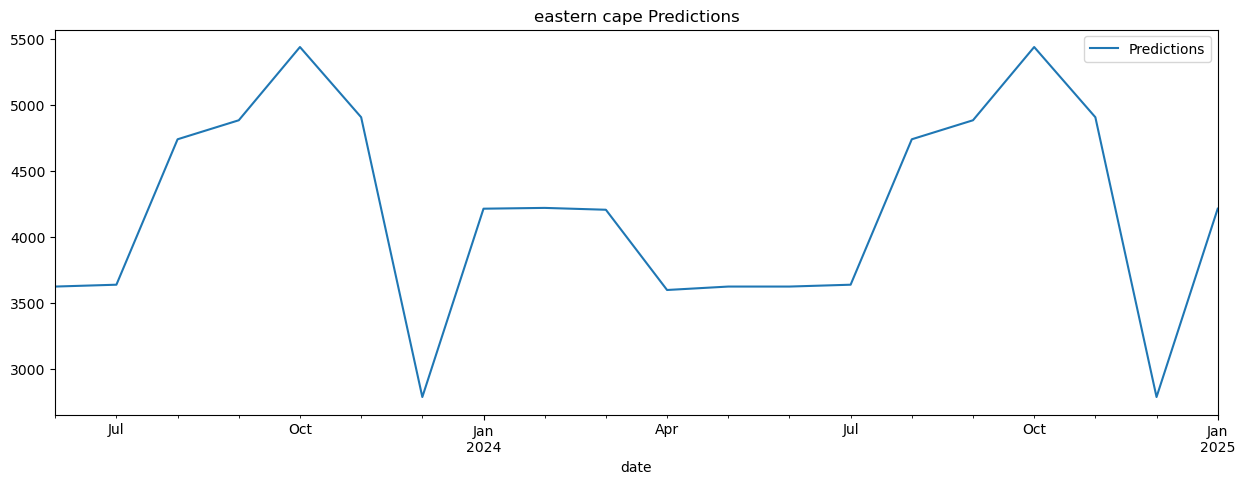

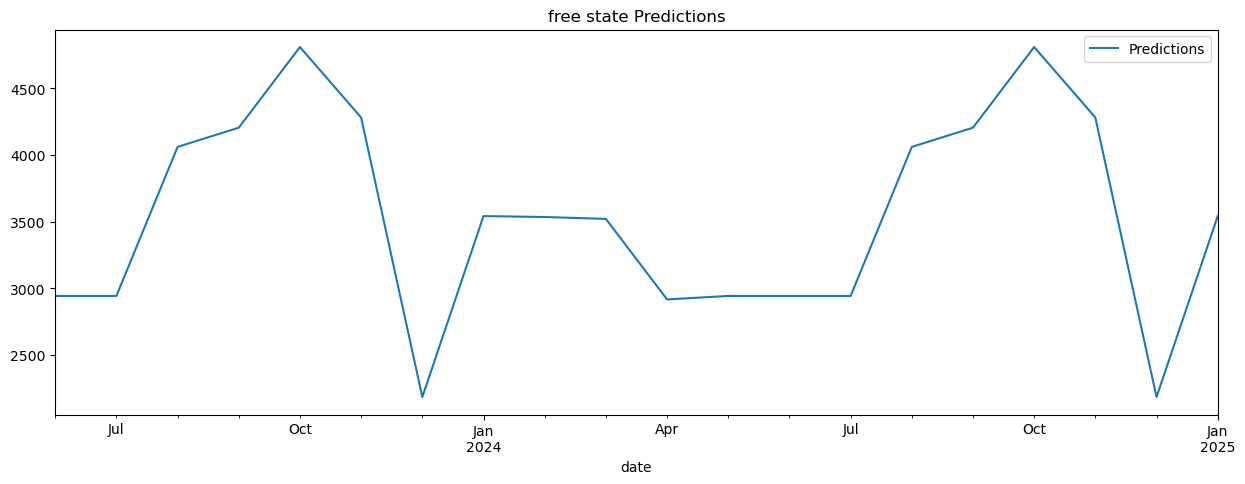

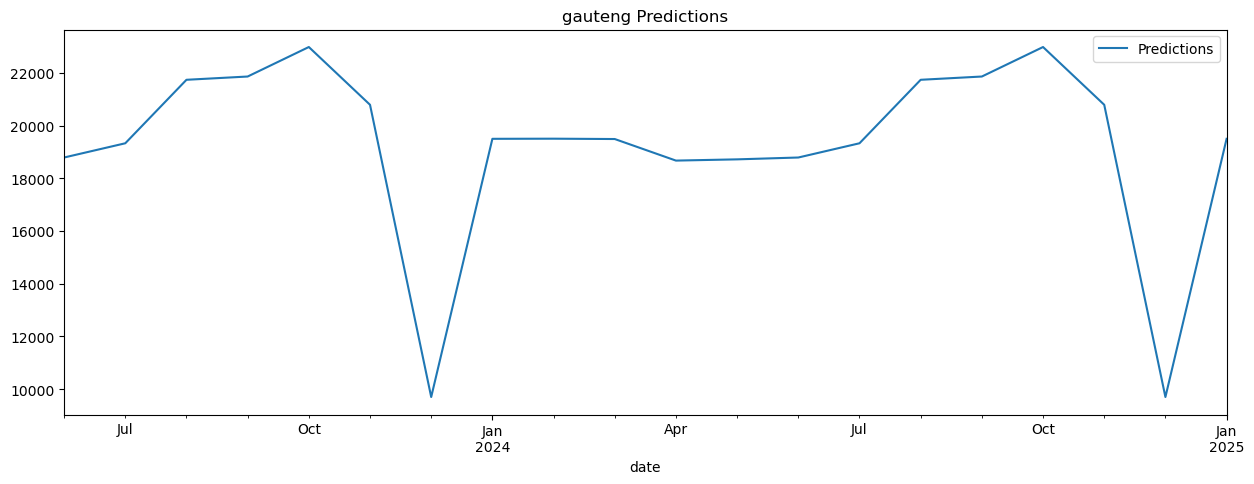

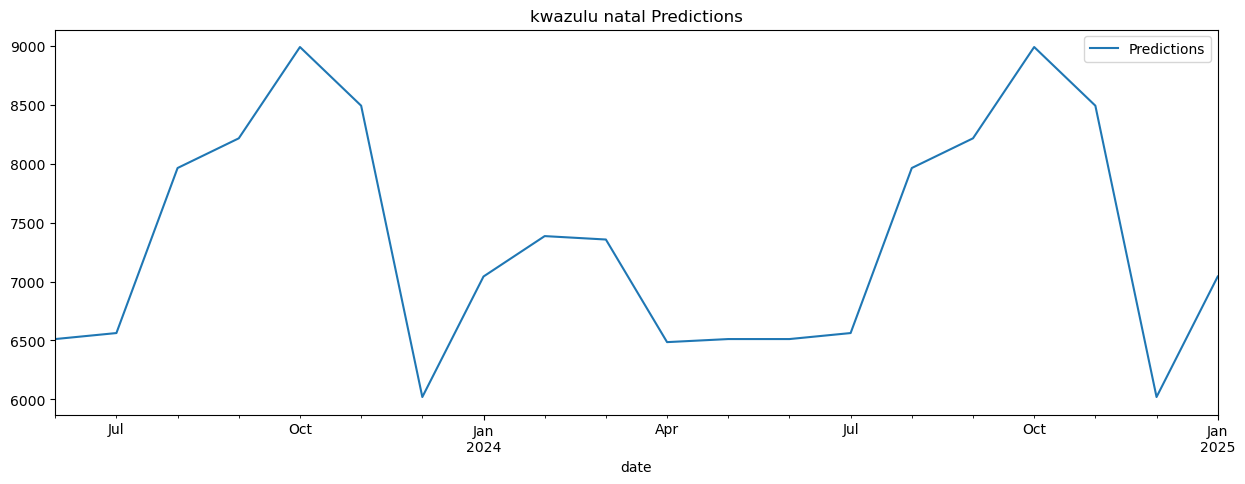

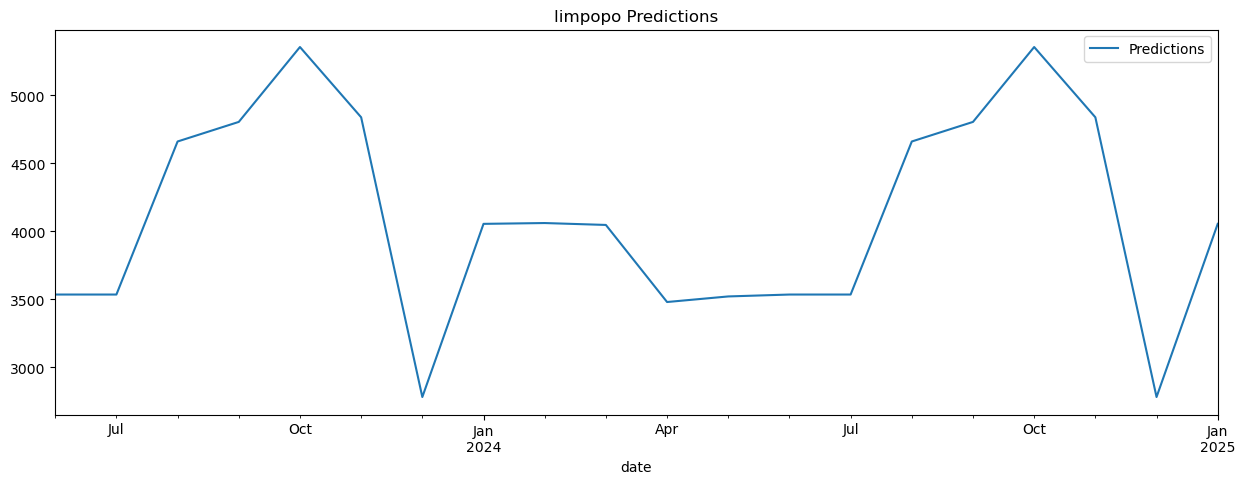

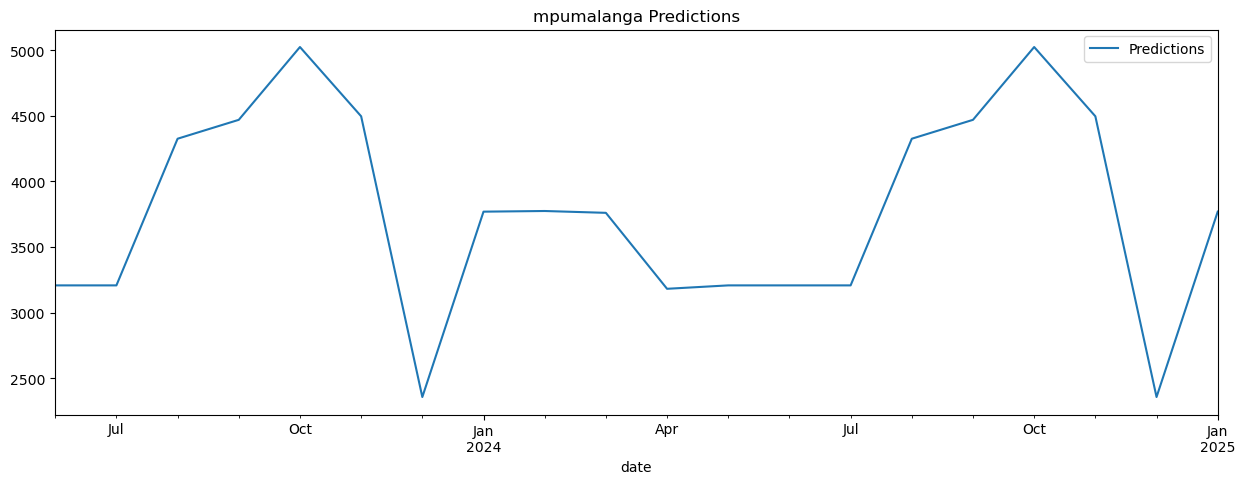

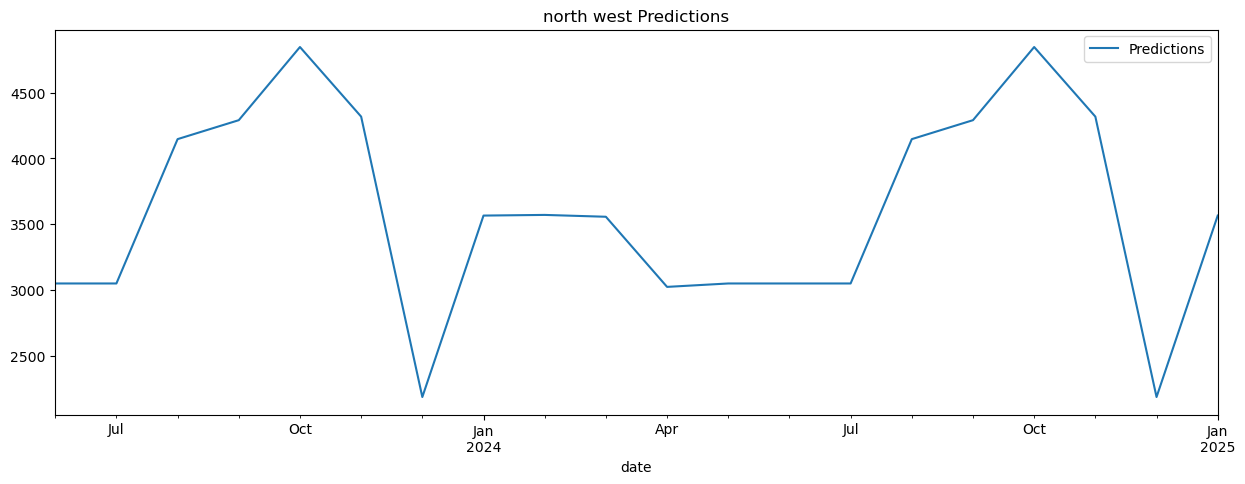

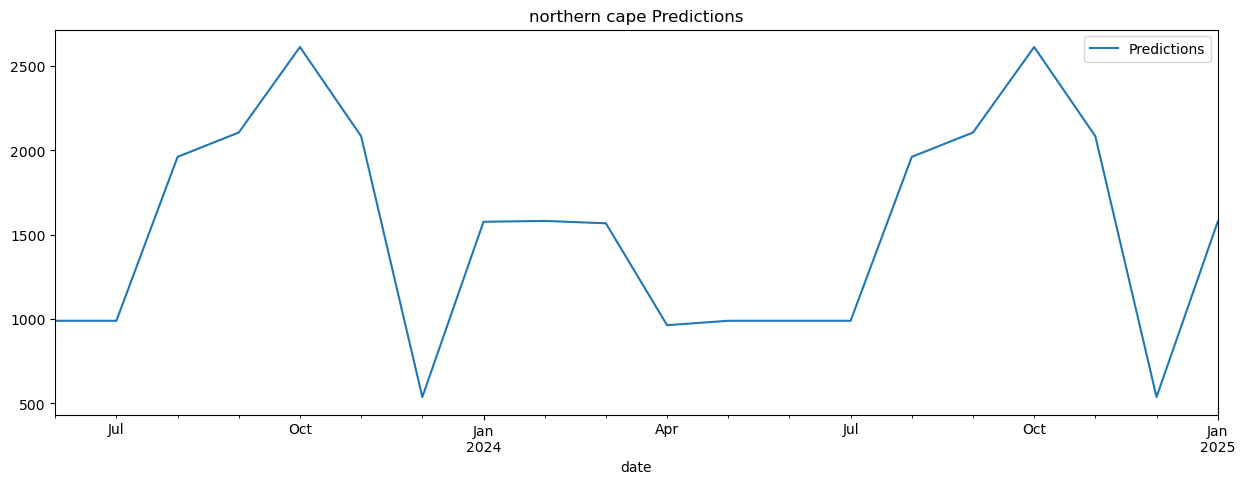

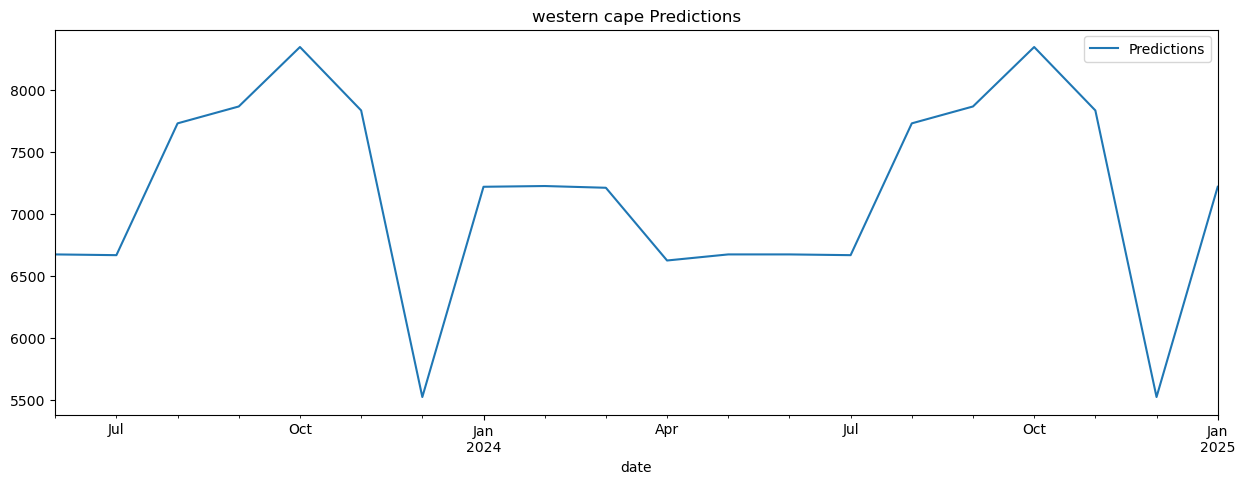

In [35]:
#plot preds
def plot_final_predictions(df_preds_func: pd.DataFrame) -> None:
    """
    Create plots illustrating predicted signups.
    :param df_preds_func: pd.DataFrame containing predictions
    :return: None    """
    provinces = df_preds_func['province'].unique()
    print(' ')
    print(' ')
    print(f'Below are plots illustrating predicted signups.')
    for province in provinces:
        df_plot = df_preds_func[df_preds_func['province']==province]
        ax = df_plot[['prediction']].plot(figsize=(15, 5))
        plt.legend(['Predictions'])
        ax.set_title(f'{province} Predictions')
        plt.show()
        
plot_final_predictions(df_final)

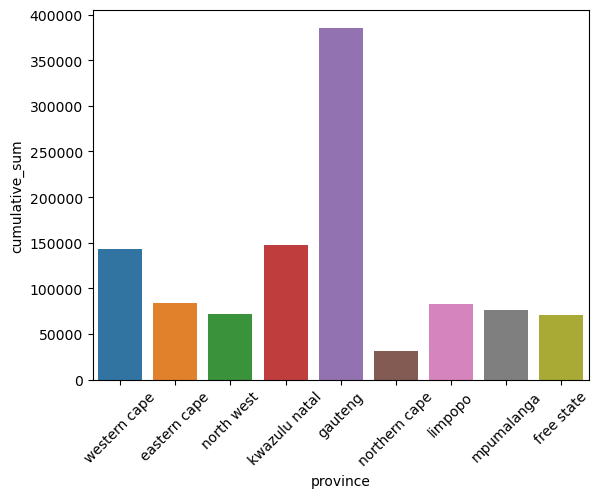

In [42]:
provinces = ['western cape',
            'eastern cape',
            'north west',
            'kwazulu natal',
            'gauteng',
            'northern cape',
            'limpopo',
            'mpumalanga',
            'free state']
df_temp = pd.DataFrame()
for province in provinces:
    df_plot = df_final[df_final['province']==province]
    df_plot = df_plot.groupby(level=0).agg('sum')
    df_plot['cumulative_sum'] = df_plot['prediction'].cumsum()
    df_plot['province'] = province
    df_temp = pd.concat([df_temp, df_plot.tail(1)], axis=0)


sns.barplot(x='province', y='cumulative_sum', data=df_temp)
plt.xticks(rotation=45) 
plt.show()

### Plot the cumulative distribution across all provinces

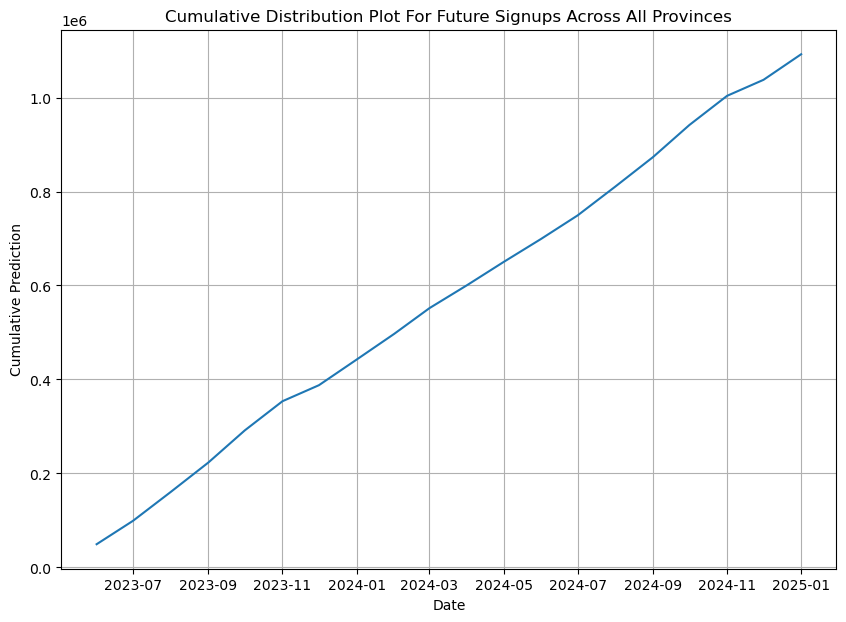

In [45]:
df_plot = df_final.sort_index()
df_plot = df_plot.groupby(level=0).agg('sum')
df_plot['cumulative_sum'] = df_plot['prediction'].cumsum()
# Plot the cumulative distribution
plt.figure(figsize=(10, 7))
plt.plot(df_plot.index, df_plot['cumulative_sum'])
plt.xlabel('Date')
plt.ylabel('Cumulative Prediction')
plt.title('Cumulative Distribution Plot For Future Signups Across All Provinces')
plt.grid(True)
plt.show()

#### According to this model there will be an additional 1 060 896 signups by 1 Jan 2025. Which means there will be a total of 2 560 896 signups.

#### 